<a href="https://colab.research.google.com/github/seaborncat/Implementation-of-Metropolis-and-Wolff-algorithm-on-Ising-model/blob/master/Ising_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Ising Model and the Metropolis Algorithm** 

**Outline of the project**

---






*   Define all componets of Ising model
*   Define Metropolis Algorithm
    *   lattice visualization
    *   Quick simulation of metropolis algorithm on 5x5 lattice to ensure everything is working fine, before implementing on 100x100 lattice.
*   Implementation on 100x100 lattice
    *   Equilibration
    *   Measurements
    *   Correlation time
    *   Calculation of thermodynamic quantities
    *   Calculation of errors
*   Collecting measurements for different lattice sizes
    * L=50
    * L=64
    * L=100
    * L=120
*   Finite size scaling 
    * critical exponents
    * errors on critical exponents

*   Tackling the problem of critical slow down with Wolff's Algorithm
    * L = 50
    * L = 64


NOTE: For best results, run all the cells sequentially as some cells depend on results from previous cells.


In [0]:
#import all the libraries which will be used in the future here.
import numpy as np
import random 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
import numba
from numba import jit
import csv
import pandas as pd


# This part is done to prevent appearance of any future warnings 
# Import warnings filter
from warnings import simplefilter
# Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# 1. Defining all components of Ising model
 

---
I will define following functions in this code bracket.


1.   To define lattice of size NxN.
2.   To calculate energy at each site and implement periodic boundary conditions
3.   To calculate total energy and total magnetization of the lattice
4.   A function to visualise lattice at any time in the code
5.   To calculate specific heat of the lattice and magnetic susceptibility





NOTE: To accelerate and optimize the code some functions are written in nopython mode using NUMBA library. Numba is a compiler that allows you to accelerate Python code (numerical functions) for both CPU and GPU. 

In [0]:
@jit(nopython=True)
def DefLattice(N): 
    lattice = np.ones((N,N))     #we will always define lattice at T=0 (that too, always all spins up)
    return lattice
    


#######################################################################

#to calculate the energy at each site, considering periodic boundary conditions
@jit(nopython=True)
def Energy_site(N,lattice,x,y): #(x,y) is the coordinates of the site on the lattice
    return (-1.0 * lattice[x][y]*(lattice[(x + 1) % N][y] +
                                        lattice[(x - 1 + N) % N][y] +
                                        lattice[x][(y + 1) % N] +
                                        lattice[x][(y - 1 + N) % N]))

##########################################################################
#to calculate the total energy
@jit(nopython=True)
def TotalEnergy(lattice,N):
    energy = 0
    for y in range(N):
        for x in range(N):
            energy += Energy_site(N,lattice,x,y)
    return energy

#########################################################################


#to calculate the total magnetization
@jit(nopython=True)
def TotalMagnetisation(lattice): #takes input of lattice 
    m = 0
    m = np.sum(lattice)
    return m
########################################################################
#to print the lattice

def Latticeshow(lattice,t):
    plt.imshow(lattice,cmap='gray')
    plt.colorbar()
    plt.title("lattice of 100x100,T=3 at time=%d"%(t))
    plt.show()
    plt.pause(0.1)
    plt.clf()    
#######################################################################
def SpecificHeat(elist,T,N):
    Emean = np.average(elist)
    Emean2 = Emean*Emean
    E2mean=sum([i**2 for i in elist])/(len(elist))
    c = (E2mean - Emean2)/(T*T*N*N)
    return c
#########################################################################

def Mag_susceptibility(mlist,T,N):
    Mmean = np.average(mlist)
    Mmean2 = Mmean*Mmean
    M2mean=sum([i**2 for i in mlist])/(len(mlist))
    s = (M2mean - Mmean2)*N*N/T
    return s


#  2.  Defining Metropolis Algorithm

---


1.   Define a lattice and initialise a starting state (T = 0 or T = $\infty$)
2.   Choose a site (x,y)
3.   Calculate the energy change $\Delta$E which results if the spin at site (x,y) is overturned
4.  If $\Delta$E $<$ 0, flip the spin
5.    Otherwise, Generate a random number r such that 0 $<$ r $<$ 1
6.   If r $<$ exp (−$\Delta$E/$k_B$T), flip the spin
7.   Repeat steps 2 to 6 

**Lattice visualization**

lattice visualization is important to understand the spin flip after each metropolis step, behaviour near critical point, and to have better understanding of the system. But on the other hand, it is very memory intensive and time intensive task, so it has been done in the beginning of the notebook only. After this, the explicit visualization of the lattice is prohibited since the code becomes time consuming.


>  2.1 lattice visualization: Here, for 100x100 lattice at T=3 the lattice after each 10000 metropolis steps has been shown.


In [0]:
def metropolis(N,steps,T):
    lattice = DefLattice(N)  
    E = TotalEnergy(lattice,N)            #calculate energy at the beginning
    M = TotalMagnetisation(lattice)     #calculate magnetization at the beginning
    n = 0      #to count the number of timesteps
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(steps):
        x = random.randrange(N)    #to generate random x cordinate
        y = random.randrange(N)    #to generate random y cordinate
        dE = -2* Energy_site(N,lattice,x,y)   #energy change cause by flipping this random site

        if (dE < 0):                   
            lattice[x][y] *= -1        
            E += dE
            M += 2*lattice[x][y]
            n += 1
            if n%10000 == 0:
                Latticeshow(lattice,n)    #to print the lattice
        elif random.random() < np.exp(-1.0 * dE/T):
            lattice[x][y] *= -1
            E += dE
            M += 2*lattice[x][y]
            n+=1
            if n%10000 == 0:
                Latticeshow(lattice,n)
        else:
            n += 1
            if n%10000 == 0:
                Latticeshow(lattice,n)

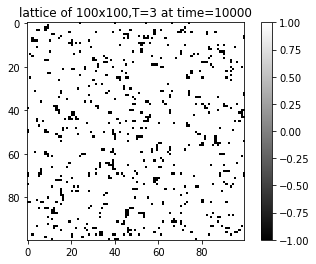

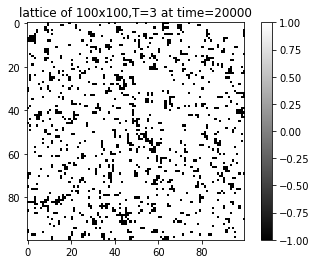

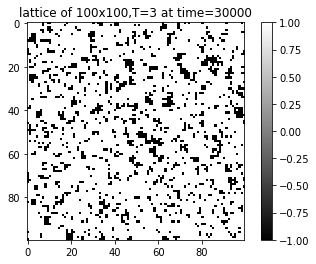

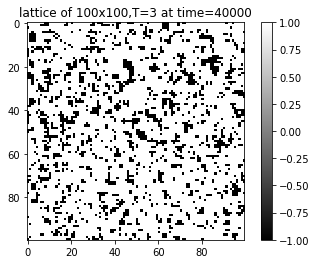

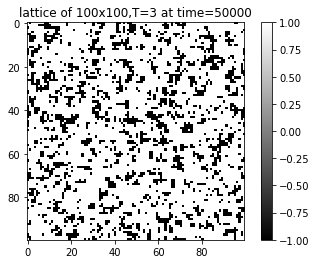

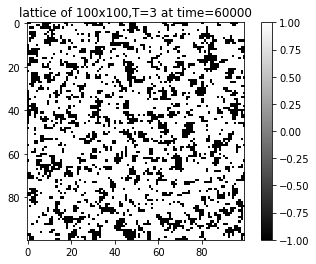

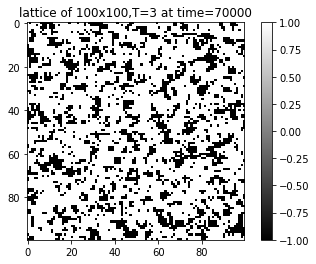

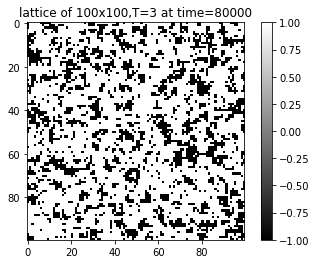

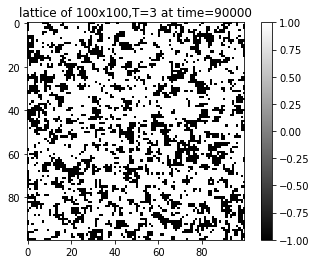

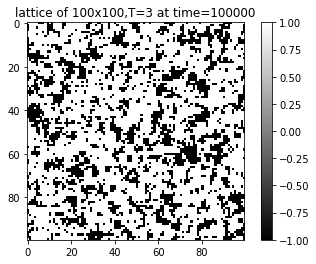

<Figure size 432x288 with 0 Axes>

In [0]:
N =100       # lattice size
steps =100000  #number of metropolis steps
metropolis(N,steps,T=3)  #calling the function at temperature, T=3

## 2.2  Quick simulation of metropolis algorithm on 5x5 lattice to ensure everything is working fine, before implementing on 100x100 lattice

Metropolis algorithm is modified to store the values of magnetization and total energy after each time per number of lattice sites. It will be used to do the further measurements. 

In [0]:
@jit(nopython=True)
def metropolis2(N,steps,lattice,T):  #modified metropolis2 algo
    E = TotalEnergy(lattice,N)
    M = TotalMagnetisation(lattice)
    Elist = []         #to store Energy at each time-step
    mlist = []         #to store Magnetization at each time-step
    n = 0
    for i in range(steps):
        x = random.randrange(N)    #to generate random x cordinate
        y = random.randrange(N)    #to generate random y cordinate
        dE = -2* Energy_site(N,lattice,x,y)   #energy change cause by flipping this random site

        if (dE < 0):                   
            lattice[x][y] *= -1        
            E += dE
            M += 2*lattice[x][y]
            if n%(N*N) == 0:
                Elist.append(E)
                mlist.append(abs(M)/(N*N))
            
        elif random.random() < np.exp(-1.0 * dE/T):
            lattice[x][y] *= -1
            E += dE
            M += 2*lattice[x][y]
            if n%(N*N) == 0:
                Elist.append(E)
                mlist.append(abs(M)/(N*N))
            
        else:                   #to store the same measurements without any change other than the time-step
            if n%(N*N) == 0:
                Elist.append(E)
                mlist.append(abs(M)/(N*N))
        n += 1
    return lattice,mlist,Elist

In [0]:
N = 5
steps = 500000
lattice = DefLattice(N)
lattice5x5_at_temp = {}     #dict to store lists of m,E
for T in np.arange(1,4,0.2):
    T = float(str('%.2f'%T))
    lattice, mlist_temp,Elist_temp = metropolis2(N,steps,lattice,T)        
    lattice5x5_at_temp[T] = [mlist_temp,Elist_temp]
    

*  20000 steps per lattice site of metropolis algorithm has been run  

*   final state of the last temperature is taken as the initial state of the next temperature.

*   then assuming that, the first few measurements will not be equillibrated, they are scraped 
*   then specific heat and magnetization is plotted against temperature.
*   If we get the expected trends we will implement the algorithm for higher lattice size

[]

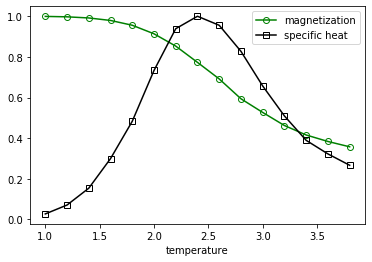

In [0]:
mlist_at_each_temp_short = []
elist_at_each_temp_short = []
Temperature = [i for i in lattice5x5_at_temp.keys()]
for i in Temperature:
    mlist_at_each_temp_short.append(lattice5x5_at_temp[i][0][-15000:])
    elist_at_each_temp_short.append(lattice5x5_at_temp[i][1][-15000:])
magnetization = [(np.average(i)) for i in mlist_at_each_temp_short]
specific_heat = [SpecificHeat(i,j,N) for i,j in zip(elist_at_each_temp_short,Temperature)]
specific_heat = specific_heat/max(specific_heat)
plt.plot(Temperature,magnetization,'-o',color='green',markerfacecolor='none',label='magnetization')
plt.plot(Temperature,specific_heat,'ks-', markerfacecolor='none',label='specific heat')
plt.xlabel('temperature')
plt.legend()
plt.plot()

# 3. Implementation of metropolis algorithm on 100x100 lattice


*   Metropolis algorithm is run for $10^9$ steps at each temperature 
*  final state of the last temperature is taken as the initial state of the next temperature to reduce the equilibration time
*  Time is recorded in steps per lattice sites.
*  Metropolis algorithm takes a lot of time to run for large number of steps, so it is advised to skip this section if you are in hurry. In next section files are attached so save the time.


In [0]:

# To save the time this cell has left commented, if you want to regenerate the data uncomment it first
# otherwise the next cell will fetch the same data from the directory
N = 100
arr100 = []
temperature = []
l = DefLattice(N)
for T in np.arange(1,4,0.1):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 1000000000
    l,m,E = metropolis2(N,steps,l,T)
    arr100.append([T,m,E])
np.save('metropolis_dataL100_10e9',arr50)


In [0]:
#to load the .npy file
m_E_data100 = np.load('metropolis_dataL100_10e9.npy',allow_pickle=True)

#to retrive the information from the above file
temperature = [i[0] for i in m_E_data100]   
m_lists100 = [i[1] for i in m_E_data100]
E_lists100 = [i[2] for i in m_E_data100]

## 3.1 Equilibration time

* We say the system is in “equilibrium” when the average probability of finding our system in any particular state $\mu$ is proportional to the Boltzmann weight exp(−$\beta E_\mu$) of that state.

* System takes suitably long period of time before it comes to equilibrium.

* magnetization has been plotted against metropolis steps to find the time system takes before coming to equilibrium at different temperature

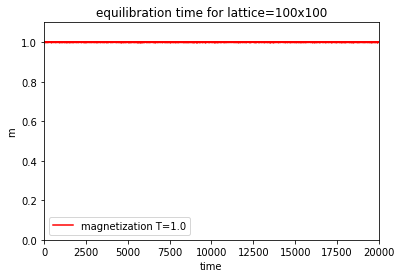

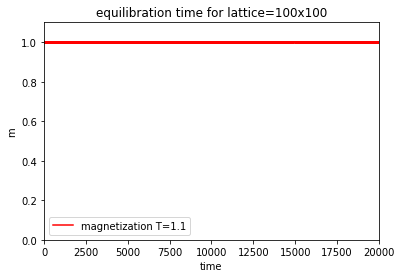

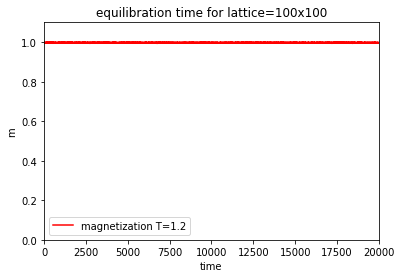

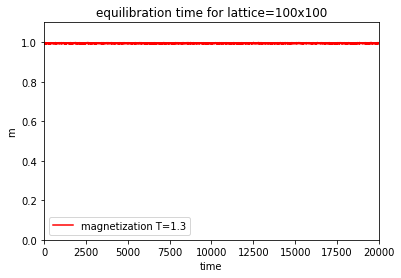

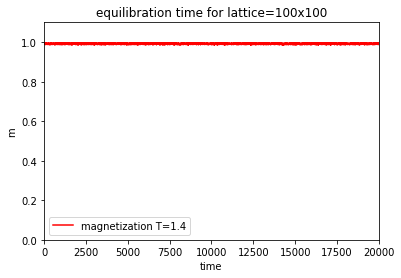

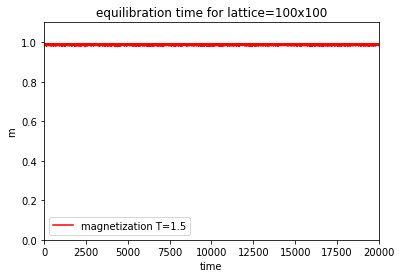

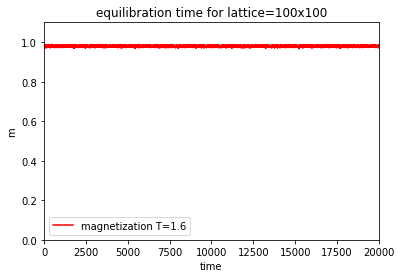

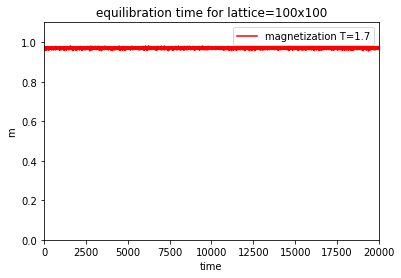

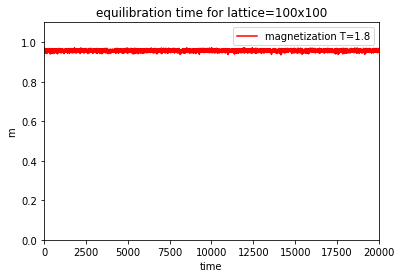

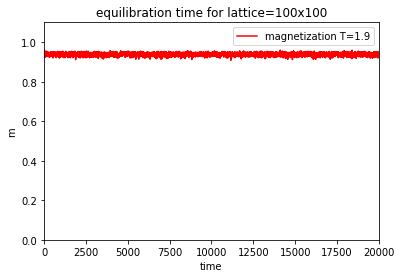

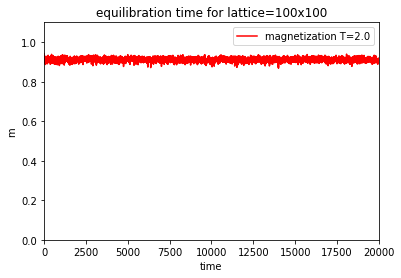

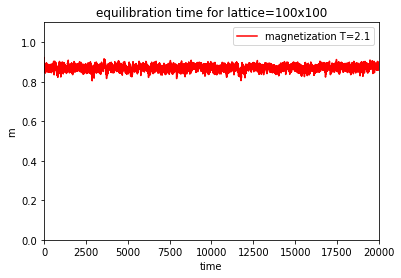

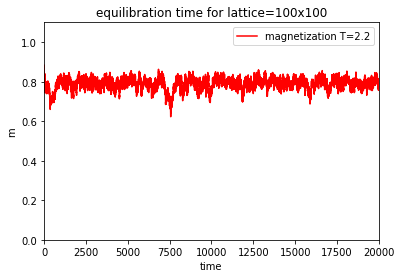

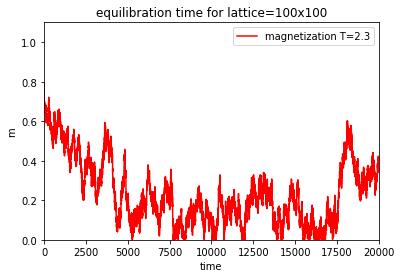

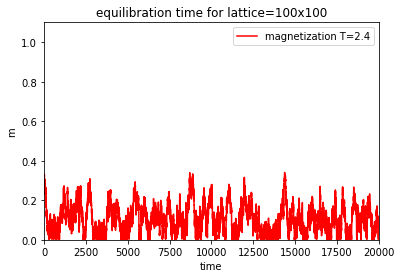

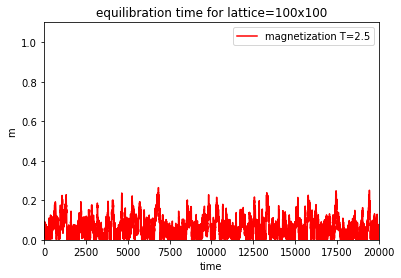

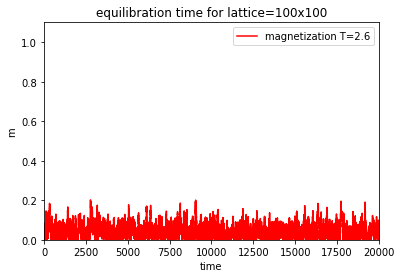

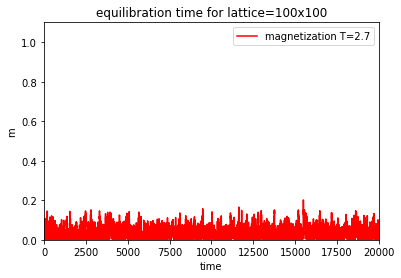

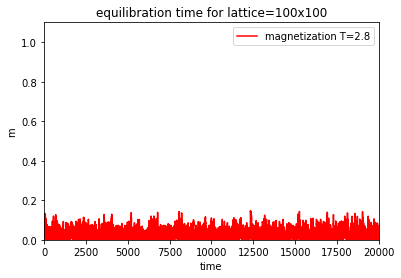

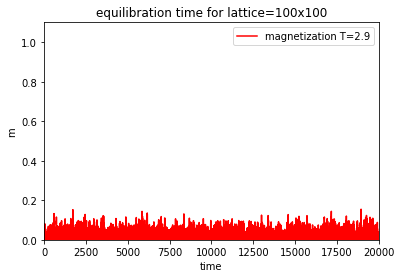

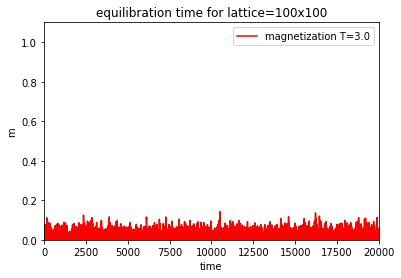

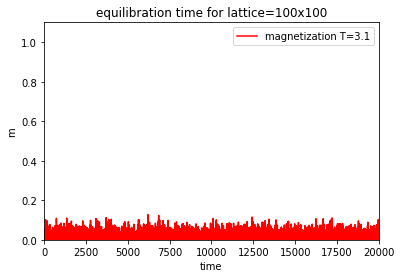

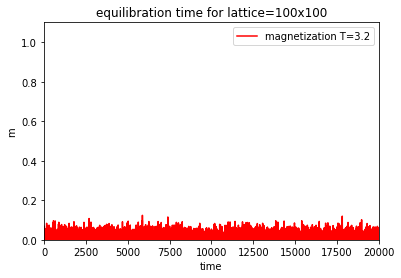

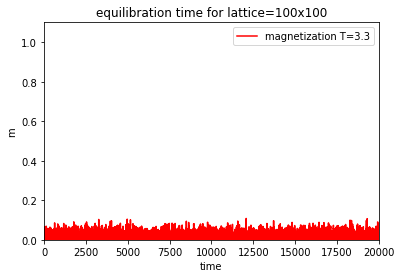

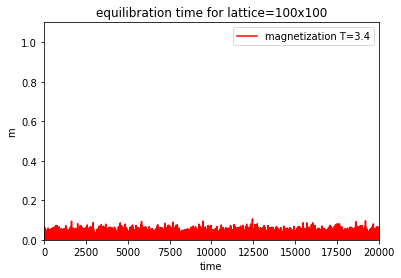

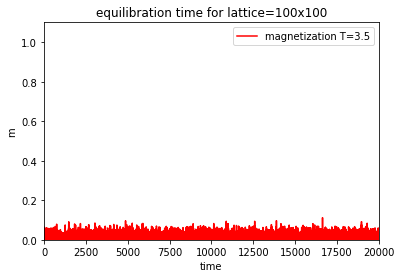

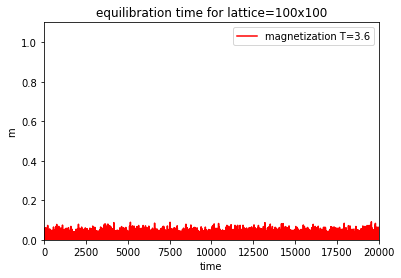

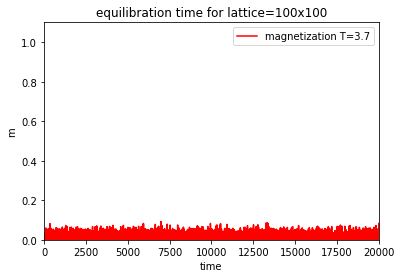

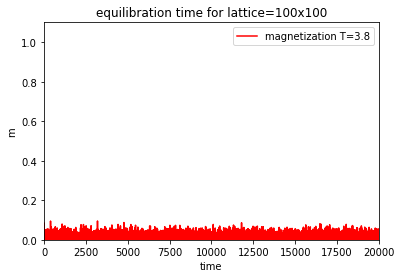

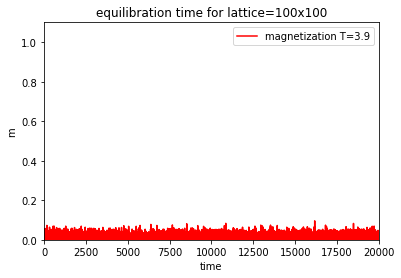

In [0]:
for i in range(len(temperature)):
    time = [t for t in range(len(m_lists100[i]))]
    plt.plot(time,m_lists100[i],color='red',label='magnetization T='+str(temperature[i]))
    plt.ylim([0,1.1])
    plt.xlim([0,20000]) #to see upto first 20k time, to get the magnified picture
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('m')
    plt.title('equilibration time for lattice=%dx%d'%(100,100))
    plt.pause(0.1)


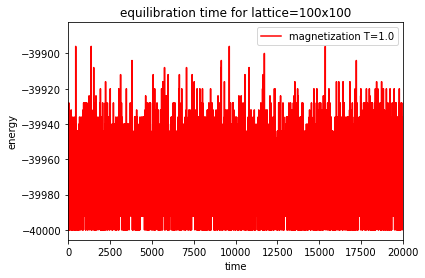

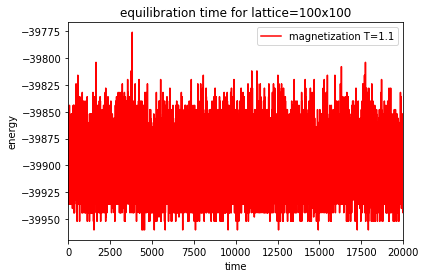

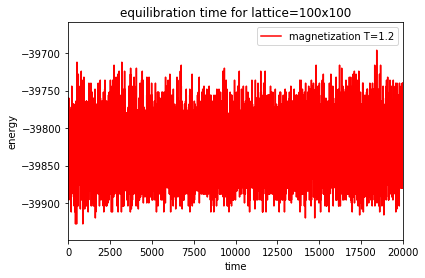

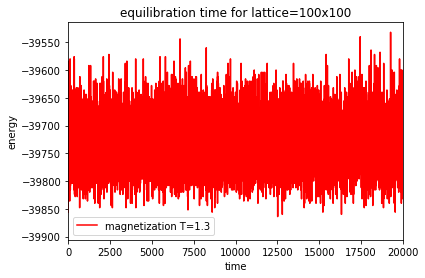

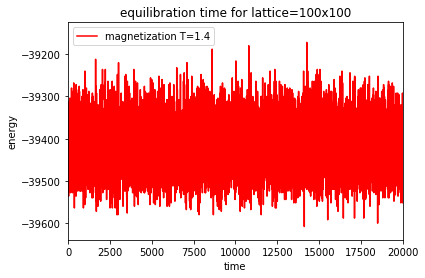

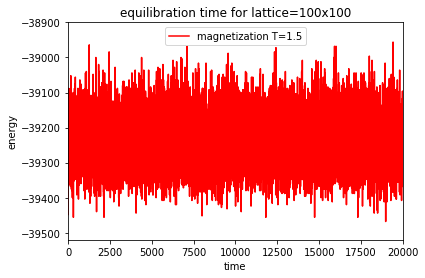

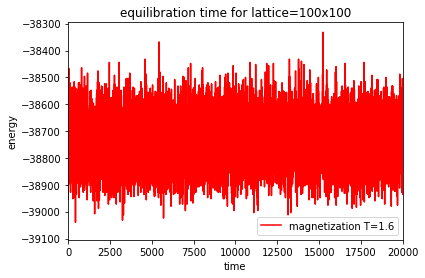

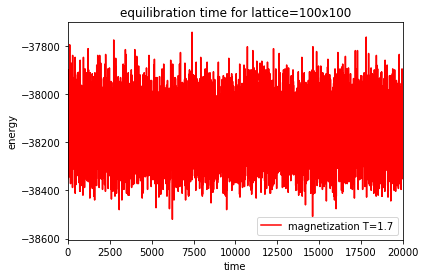

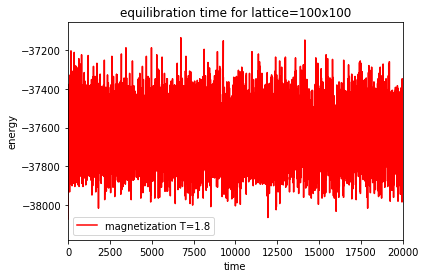

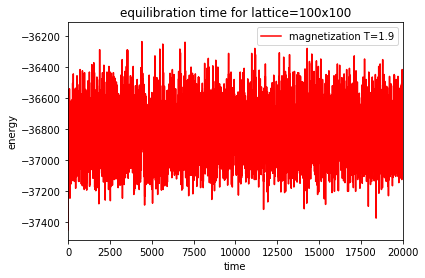

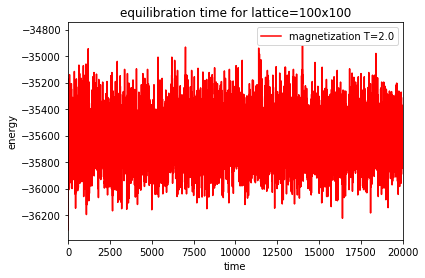

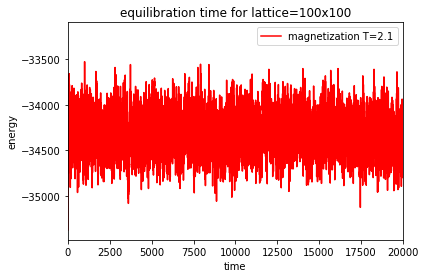

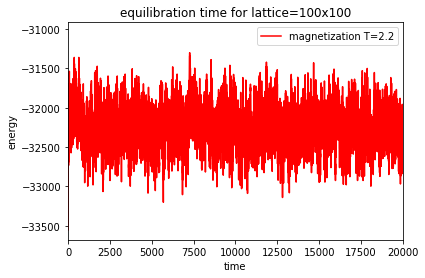

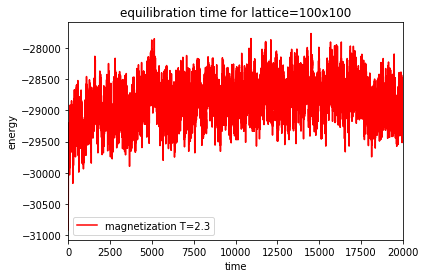

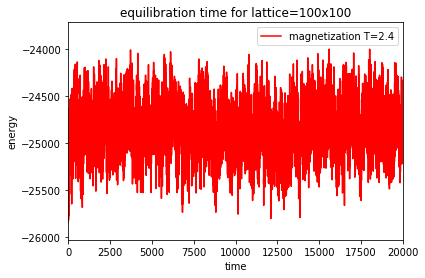

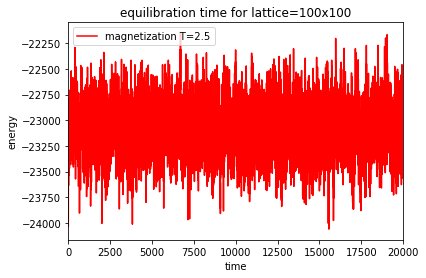

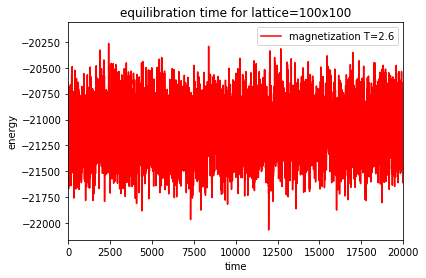

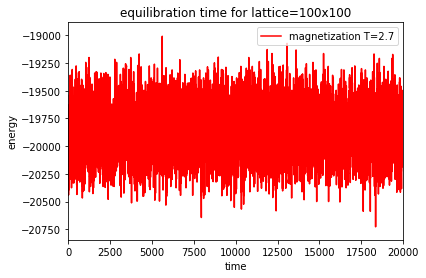

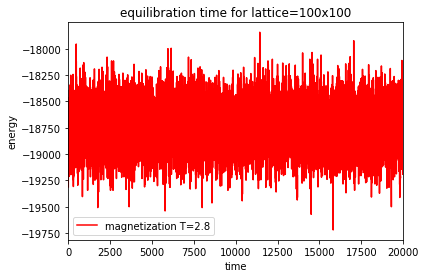

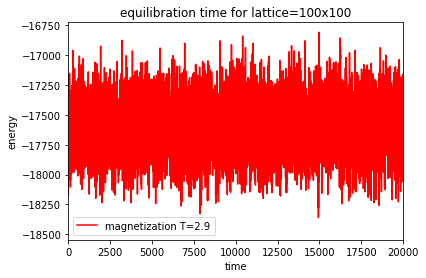

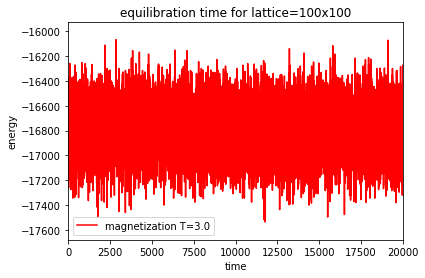

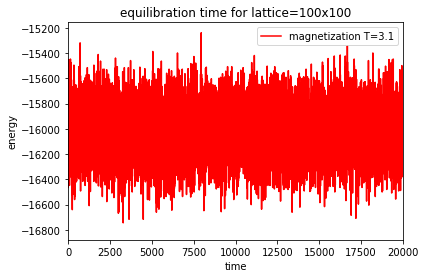

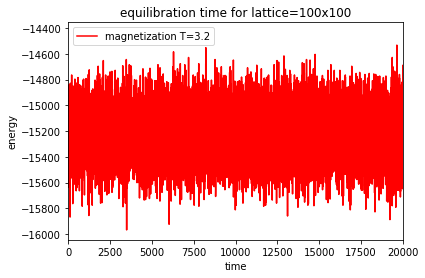

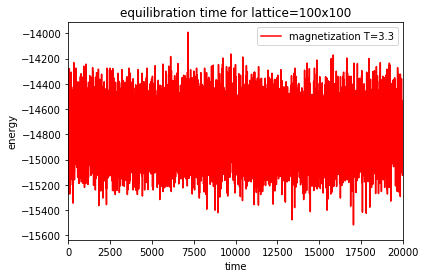

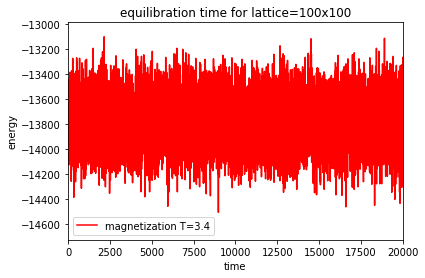

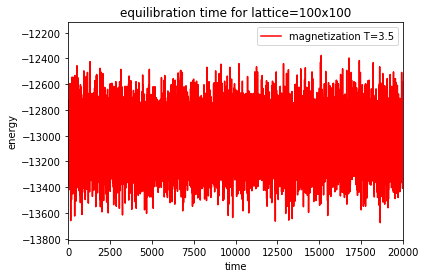

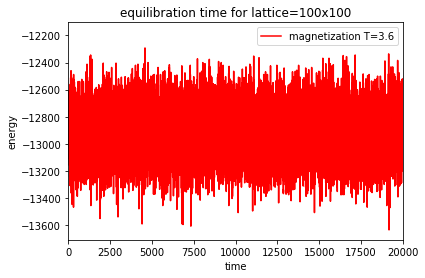

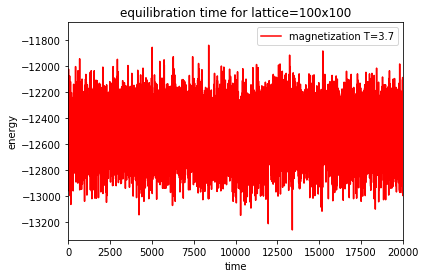

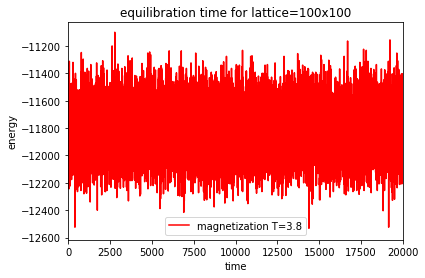

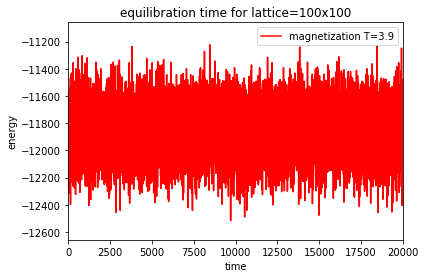

In [0]:
for i in range(len(temperature)):
    time = [t for t in range(len(E_lists100[i]))]
    plt.plot(time,E_lists100[i],color='red',label='magnetization T='+str(temperature[i]))
    #plt.ylim([-4000,0])
    plt.xlim([0,20000]) #to see upto first 20k time, to get the magnified picture
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('energy')
    plt.title('equilibration time for lattice=%dx%d'%(100,100))
    plt.pause(0.1)

we can see that, energy has more fluctuations than magnetization but it comes to equilibrium more quickly. After around 10,000 timesteps we will assume that we get equilibrated values of m and E.  We will discard the initial entries from the list.

In [0]:
mlist_after_equilibrium = []    #lists to store equilibrated values
elist_after_equilibrium = []
for i in range(len(temperature)):
    mlist_after_equilibrium.append(m_lists100[i][-90000:])
    elist_after_equilibrium.append(E_lists100[i][-90000:])

## 3.3 Correlation time


*   correlation time is a measure of how long it takes to the system to go to completely different state from the previous state.
*   The time-displaced auto-correlation function is defined to measure the correlation time. 

In [0]:
# the function takes the input of mlist, tmax=maximum time for which magnetization has been recorded 
                            #and t1 = interval(at what interval we want to get correlation between 2 measurements)
def autocorrelation(m,tmax,t1):  
    corr = []
    time =[]
    for t in np.arange(1,tmax,t1):
        term1 = 0
        term2 = 0
        term3 = 0
        coefficient = 1/(tmax-t)
        for tdash in range(tmax-t):
            term1 += m[tdash]*m[tdash+t]
            term2 += m[tdash]
            term3 += m[tdash+t]
        corr.append(coefficient*term1- coefficient*term2*coefficient*term3 )
        time.append(t)
    return time,corr

def func(x,tou):   #fitting function
    return np.exp(-x/tou)

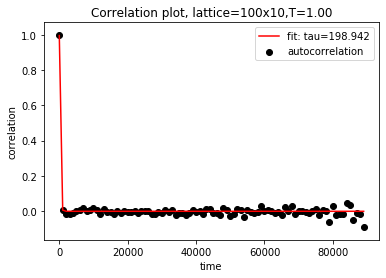

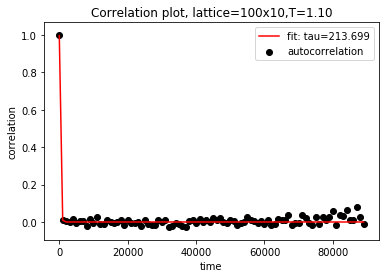

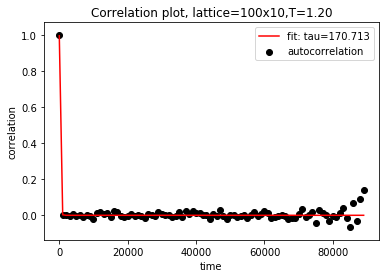

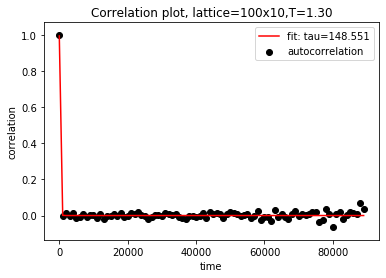

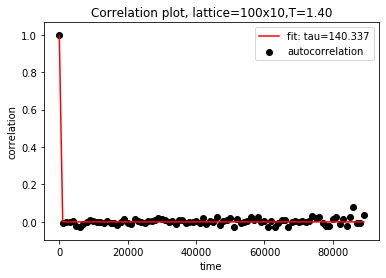

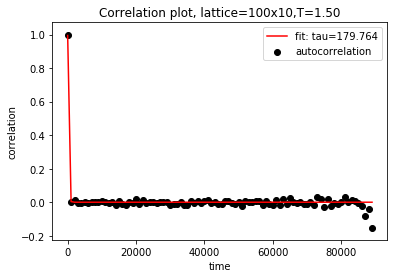

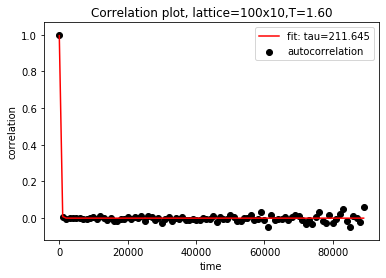

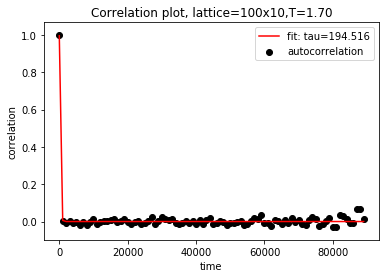

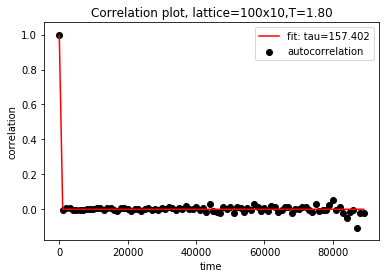

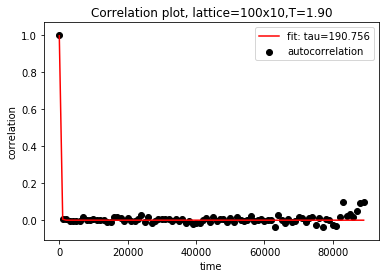

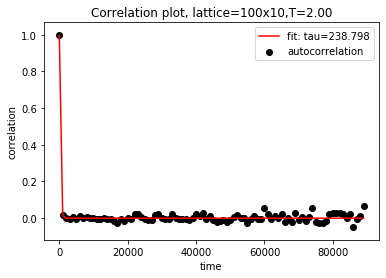

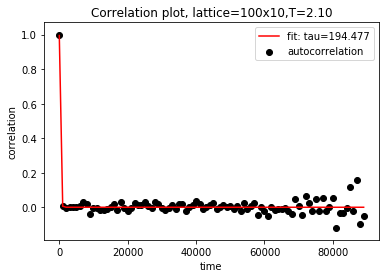

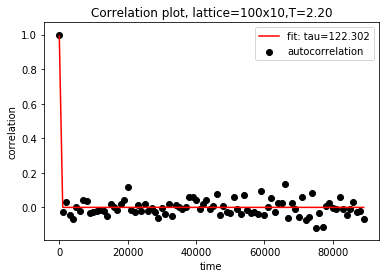

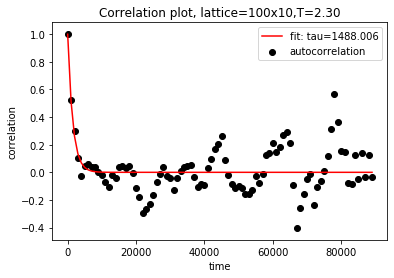

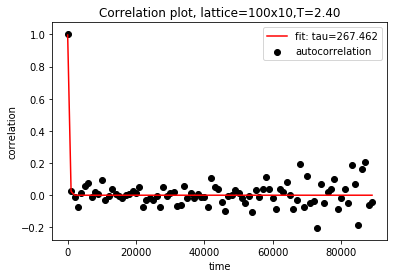

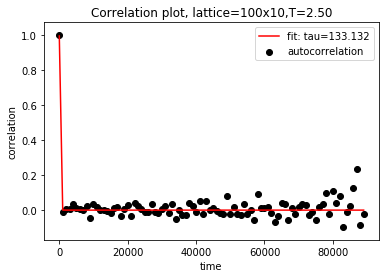

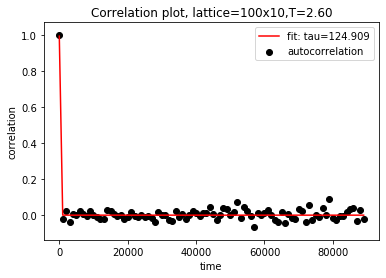

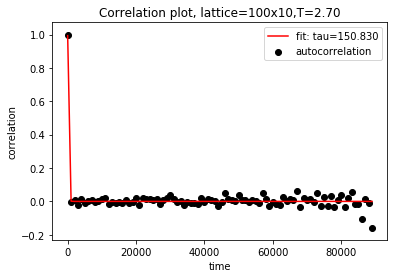

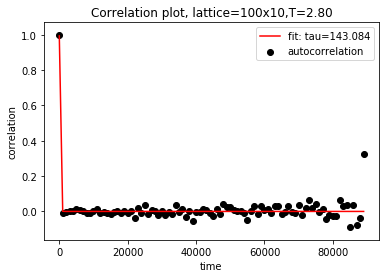

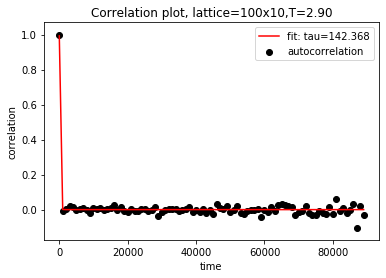

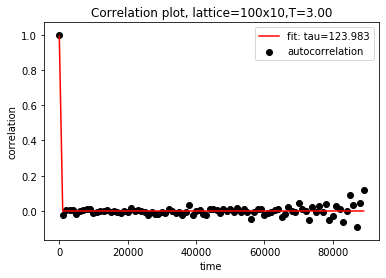

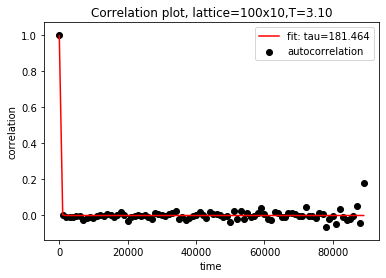

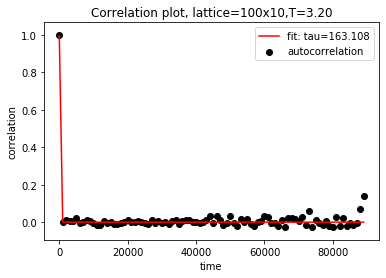

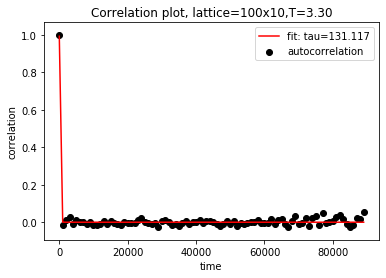

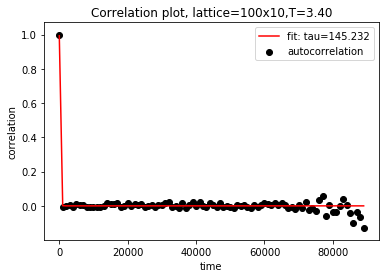

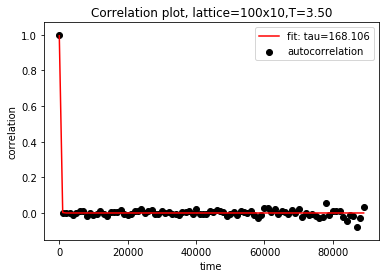

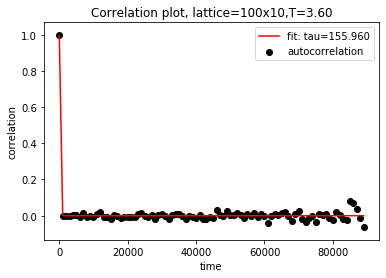

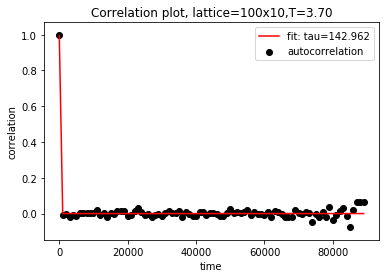

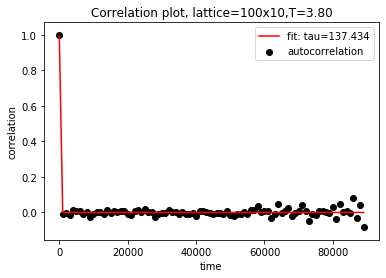

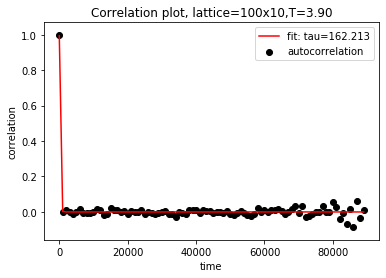

In [0]:
correlation_time = {}     #to save temperature and its corresponding correlation time

for i in range(len(temperature)):
    t,corr = autocorrelation(mlist_after_equilibrium[i],90000,1000)
    corr = np.array(corr)
    t = np.array(t)
    corr= corr/np.max(corr)
    popt, pcov = curve_fit(func, t, corr)
    correlation_time[temperature[i]] = popt[0]
    plt.scatter(t,corr,color='black',label='autocorrelation')
    plt.plot(t, func(t, *popt), 'r-',label='fit: tau=%5.3f' %(popt))
    plt.xlabel('time')
    plt.ylabel('correlation')
    plt.title("Correlation plot, lattice=100x10,T=%.2f"%(temperature[i]))
    plt.legend()
    plt.pause(0.1)

* Now we will plot the correlation time vs temperature graph to visualise how one vary wrt other.
* We expect large correlation time near critical region


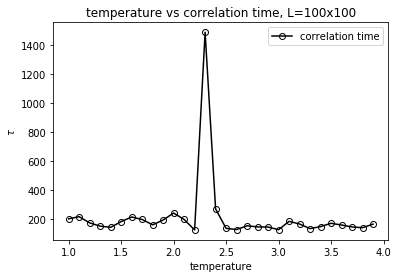

In [0]:
plt.plot(list(correlation_time.keys()), list(correlation_time.values()),'ko-',markerfacecolor='none',label='correlation time')
plt.ylabel(r'$\tau$')
plt.xlabel('temperature')
plt.title('temperature vs correlation time, L=100x100')
plt.legend()
plt.show()

* now we will extract the independent measurements according to correlation time at that temperature.
* Here we will take measurements after 1 correlation time so that we get enough measurements to have good statistics

In [0]:
mag_measurements = []
energy_measurements = []
for i in range(len(temperature)):
    temp1 = []
    temp2 = []
    for j in range(len(mlist_after_equilibrium[i])):
        if j%round(correlation_time[temperature[i]])==0:
            temp1.append(mlist_after_equilibrium[i][j])
            temp2.append(elist_after_equilibrium[i][j])
  
    mag_measurements.append(temp1)
    energy_measurements.append(temp2)

## 3.4 Calculation of thermodynamic quantities
* After collecting the independent measurements we will compute the thermodynamic quantities like,
    * magnetization per lattice site
    * specific heat
    * magnetic susceptibility

[]

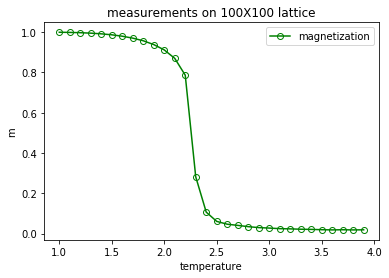

In [0]:
magnetization = [np.average(i) for i in mag_measurements]
plt.plot(temperature,magnetization,'o-',color='green',markerfacecolor='none',label='magnetization')
plt.xlabel('temperature')
plt.ylabel('m')
plt.title('measurements on 100X100 lattice')
plt.legend()
plt.plot()

[]

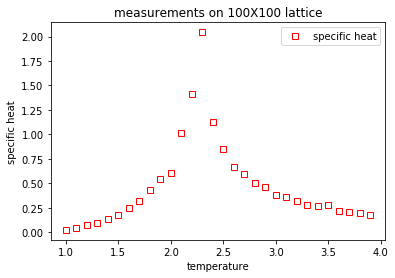

In [0]:
specific_heat = [SpecificHeat(i,j,100) for i,j in zip(energy_measurements,temperature)]
plt.plot(temperature,specific_heat,'rs', markerfacecolor='none',label='specific heat')
plt.xlabel('temperature')
plt.ylabel('specific heat')
plt.title('measurements on 100X100 lattice')
plt.legend()
plt.plot()

[]

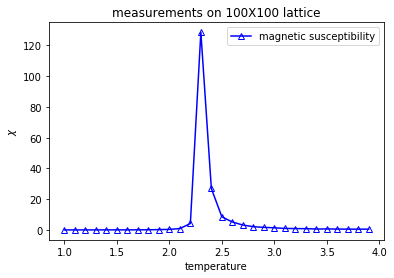

In [0]:
mag_suscep = [Mag_susceptibility(i,j,100) for i,j in zip(mag_measurements,temperature)]
plt.plot(temperature,mag_suscep,'b^-', markerfacecolor='none',label='magnetic susceptibility')
plt.xlabel('temperature')
plt.ylabel(r'$\chi$')
plt.title('measurements on 100X100 lattice')
plt.legend()
plt.plot()

##  3.5 Error calculation

* To calculate the errors in derived quantities like specific heat and susceptibility we define the function Jackniffe.




In [0]:
#this function takes the measurements of energy/mag at given temperature and lattice size; returns error
def jackknife(Elist,N):     #N = lattice size
    errors = []
    for i,t in zip(Elist,temperature):
        c_values = []
        c = SpecificHeat(i,t,N)
        for j in range(len(i)):
            temp = i.pop(0)
            c_values.append(SpecificHeat(i,t,N))
            i.append(temp)
        sigma_square = [(k-c)*(k-c) for k in c_values]
        sigma = np.sqrt(np.sum(sigma_square))
        errors.append(sigma)
    return errors

#for errors in magnetization
def error_magnetization(mlist):
    errors = []
    for i in mlist:
        errors.append(np.std(i))
    return errors

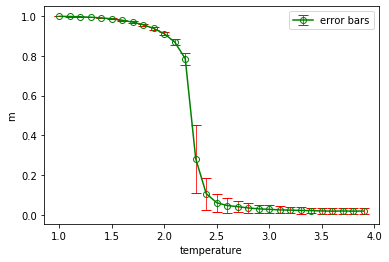

In [0]:
errors_in_magnetization = error_magnetization(mag_measurements) 
plt.errorbar(temperature,magnetization, yerr=errors_in_magnetization,capsize=5.0,ecolor='red',fmt='og-',markerfacecolor='none',elinewidth=0.8,label='error bars')
plt.xlabel('temperature')
plt.ylabel('m')
plt.legend()
plt.show()

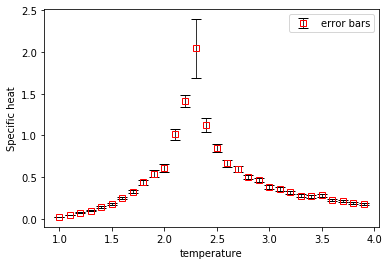

In [0]:
errors_specific_heat  = jackknife(energy_measurements,100)
plt.errorbar(temperature,specific_heat, yerr=errors_specific_heat,fmt='rs',capsize=5.0,ecolor='black',markerfacecolor='none',elinewidth=0.8,label='error bars')
plt.xlabel('temperature')
plt.ylabel('Specific heat')
plt.legend()
plt.show()

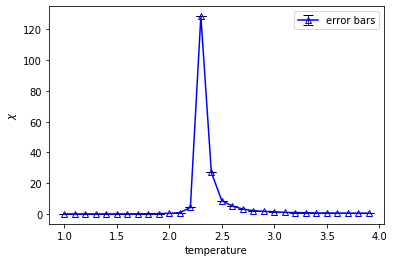

In [0]:
errors_suscep  = jackknife(mag_measurements,100)
plt.errorbar(temperature,mag_suscep, yerr=errors_suscep,fmt='b^-',capsize=5.0,ecolor='black',markerfacecolor='none',elinewidth=0.8,label='error bars')
plt.xlabel('temperature')
plt.ylabel(r'$\chi$')
plt.legend()
plt.show()

# 4. Collecting measurements for different lattice sizes

* We will make a new class consisting all the functions above as its methods. It will ease our work,save time, and reduce the complexity of our code.
* the class below might look huge but, basically, it is a combination of all the methods we saw earlier.
* We will record measurements for different lattice sizes namely, L=50, L=64, L=100, and L=120.

NOTE: Use of the class should be done as prescribed in the examples. Sequence of calling the methods is important here.

Reader can also skip this section because it applies same treatment to different lattice sizes as above.

In [0]:
class Measurements():
    
    def __init__(self,N,m_E_data):
        self.N = N
        self.temperature = [i[0] for i in m_E_data]
        self.m_lists = [i[1] for i in m_E_data]
        self.E_lists = [i[2] for i in m_E_data]
        self.mlist_after_equilibrium = []
        self.elist_after_equilibrium = []
        self.correlation_time = {}
        self.mag_measurements = []
        self.energy_measurements = []
        self.final_mag_measurements = []
        self.final_specificheat_measurements = []
        self.final_mag_susceptibility = []
        self.errors_in_magnetization = []
        self.errors_specific_heat = []
        self.errors_mag_susc = []
        
    def equilibration(self):
        for i in range(len(self.temperature)):
            time = [t for t in range(len(self.m_lists[i]))]
            plt.plot(time,self.m_lists[i],color='red',label='magnetization T='+str(self.temperature[i]))
            plt.ylim([0,1.1])
            plt.legend()
            plt.xlabel('time')
            plt.ylabel('m')
            plt.title('equilibration time for lattice=%dx%d'%(self.N,self.N))
            plt.pause(0.1)
        
    def lists_after_equilibration(self,k):
        self.k = k
        for i in range(len(self.temperature)):
            self.mlist_after_equilibrium.append(self.m_lists[i][-k:])
            self.elist_after_equilibrium.append(self.E_lists[i][-k:])
  
    
    def autocorrelation(self,m,tmax,t1):  
        corr = []
        time =[]
        for t in np.arange(1,tmax,t1):
            term1 = 0
            term2 = 0
            term3 = 0
            coefficient = 1/(tmax-t)
            for tdash in range(tmax-t):
                term1 += m[tdash]*m[tdash+t]
                term2 += m[tdash]
                term3 += m[tdash+t]
            corr.append(coefficient*term1- coefficient*term2*coefficient*term3 )
            time.append(t)
        return time,corr

    def func(self,x,tou):
        return np.exp(-x/tou)
    
    def plot_correlation(self,interval):
        for i in range(len(self.temperature)):
            t,corr = self.autocorrelation(self.mlist_after_equilibrium[i],self.k,interval)
            corr = np.array(corr)
            t = np.array(t)
            corr= corr/np.max(corr)
            popt, pcov = curve_fit(self.func, t, corr)
            self.correlation_time[self.temperature[i]] = popt[0]
            plt.scatter(t,corr,color='black',label='autocorrelation')
            plt.plot(t, self.func(t, *popt), 'r-',label='fit: tau=%5.3f' %(popt))
            plt.xlabel('time')
            plt.ylabel('correlation')
            plt.title("Correlation plot, lattice=%dx%d,T=%.2f"%(self.N,self.N,self.temperature[i]))
            plt.legend()
            plt.pause(0.1)
     
    def temp_vs_corr(self):
        plt.plot(list(self.correlation_time.keys()), list(self.correlation_time.values()),'ko-',markerfacecolor='none',label='correlation time')
        plt.ylabel(r'$\tau$')
        plt.xlabel('temperature')
        plt.title("Correlation time vs T plot, lattice=%dx%d"%(self.N,self.N))
        plt.legend()
        plt.show()
        
    def final_measurements(self):
        for i in range(len(self.temperature)):
            temp1 = []
            temp2 = [] 
            if self.correlation_time[self.temperature[i]]<20:
                for j in range(len(self.mlist_after_equilibrium[i])):
                    if j%25==0:
                        temp1.append(self.mlist_after_equilibrium[i][j])
                        temp2.append(self.elist_after_equilibrium[i][j])
                self.mag_measurements.append(temp1)
                self.energy_measurements.append(temp2)
            else:
                for j in range(len(self.mlist_after_equilibrium[i])):
                    if j%round(self.correlation_time[self.temperature[i]])==0:
                        temp1.append(self.mlist_after_equilibrium[i][j])
                        temp2.append(self.elist_after_equilibrium[i][j])
                self.mag_measurements.append(temp1)
                self.energy_measurements.append(temp2)
    
    def final_measurements_wolff(self):
        for i in range(len(self.temperature)):
            temp1 = []
            temp2 = [] 
            if self.correlation_time[self.temperature[i]]<5:
                for j in range(len(self.mlist_after_equilibrium[i])):
                    if j%5==0:
                        temp1.append(self.mlist_after_equilibrium[i][j])
                        temp2.append(self.elist_after_equilibrium[i][j])
                self.mag_measurements.append(temp1)
                self.energy_measurements.append(temp2)
            else:
                for j in range(len(self.mlist_after_equilibrium[i])):
                    if j%round(self.correlation_time[self.temperature[i]])==0:
                        temp1.append(self.mlist_after_equilibrium[i][j])
                        temp2.append(self.elist_after_equilibrium[i][j])
                self.mag_measurements.append(temp1)
                self.energy_measurements.append(temp2)
        
    
    def SpecificHeat(self,elist,T,N):
        Emean = np.average(elist)
        Emean2 = Emean*Emean
        E2mean=sum([i**2 for i in elist])/(len(elist))
        c = (E2mean - Emean2)/(T*T*N*N)
        return c
    def Mag_susceptibility(self,mlist,T,N):
        Mmean = np.average(mlist)
        Mmean2 = Mmean*Mmean
        M2mean=sum([i**2 for i in mlist])/(len(mlist))
        s = (M2mean - Mmean2)*N*N/T
        return s
        
    def error_magnetization(self,mlist):
        errors = []
        for i in mlist:
            errors.append(np.std(i))
        return errors
    
    def jackknife1(self,Elist):     #for specific heat
        errors = []
        for i,t in zip(Elist,self.temperature):
            c_values = []
            c = self.SpecificHeat(i,t,self.N)
            for j in range(len(i)):
                temp = i.pop(0)
                c_values.append(self.SpecificHeat(i,t,self.N))
                i.append(temp)
            sigma_square = [(k-c)*(k-c) for k in c_values]
            sigma = np.sqrt(np.sum(sigma_square))
            errors.append(sigma)
        return errors
    
    def jackknife2(self,Mlist):     #for magnetic susceptibility
        errors = []
        for i,t in zip(Mlist,self.temperature):
            c_values = []
            c = self.Mag_susceptibility(i,t,self.N)
            for j in range(len(i)):
                temp = i.pop(0)
                c_values.append(self.Mag_susceptibility(i,t,self.N))
                i.append(temp)
            sigma_square = [(k-c)*(k-c) for k in c_values]
            sigma = np.sqrt(np.sum(sigma_square))
            errors.append(sigma)
        return errors
  
    def plot_magnetization(self):
        self.final_mag_measurements = [np.average(i) for i in self.mag_measurements]
        self.errors_in_magnetization = self.error_magnetization(self.mag_measurements) 
        plt.errorbar(self.temperature,self.final_mag_measurements, yerr=self.errors_in_magnetization,capsize=5.0,ecolor='red',fmt='og',markerfacecolor='none',elinewidth=0.5,label='error bars')
        plt.xlabel('temperature')
        plt.ylabel('m')
        plt.title('magnetization plot, lattice=%dx%d'%(self.N,self.N))
        plt.legend()
        plt.show()
        
    def plot_specific_heat(self):
        self.final_specificheat_measurements = [self.SpecificHeat(i,j,self.N) for i,j in zip(self.energy_measurements,self.temperature)]
        self.errors_specific_heat  = self.jackknife1(self.energy_measurements)
        plt.errorbar(self.temperature,self.final_specificheat_measurements, yerr=self.errors_specific_heat,fmt='ok',capsize=5.0,ecolor='red',markerfacecolor='none',elinewidth=0.8,label='error bars')
        plt.xlabel('temperature')
        plt.ylabel('Specific heat')
        plt.title('specific heat, lattice=%dx%d'%(self.N,self.N))
        plt.legend()
        plt.show()
        
    def plot_mag_susceptibility(self):
        self.final_mag_susceptibility = [self.Mag_susceptibility(i,j,self.N) for i,j in zip(self.mag_measurements,self.temperature)]
        self.errors_mag_susc  = self.jackknife2(self.mag_measurements)
        plt.errorbar(self.temperature,self.final_mag_susceptibility, yerr=self.errors_mag_susc,fmt='ok',capsize=5.0,ecolor='red',markerfacecolor='none',elinewidth=0.8,label='error bars')
        plt.xlabel('temperature')
        plt.ylabel(r'$\chi$')
        plt.title('magnetic susceptibility plot, lattice=%dx%d'%(self.N,self.N))
        plt.legend()
        plt.show()
    def save_file(self):
        filename = "measurementsL%d.csv"%(self.N)
        fields = ['temperature','magnetization','mag error','specific heat','sp.heat error' ,'mag susceptibility','suscep error']
        with open(filename, 'w') as csvfile:  
            # creating a csv writer object  
            csvwriter = csv.writer(csvfile)  
            # writing the fields  
            csvwriter.writerow(fields)
            csvwriter.writerows(zip(self.temperature,self.final_mag_measurements,self.errors_in_magnetization ,self.final_specificheat_measurements,self.errors_specific_heat,self.final_mag_susceptibility,self.errors_mag_susc))

In [0]:
#modified metropolis to save data after little long time
@jit(nopython=True)
def metropolis3(N,steps,lattice,T):  #modified metropolis3 algo
    E = TotalEnergy(lattice,N)
    M = TotalMagnetisation(lattice)
    Elist = []         #to store Energy at each time-step
    mlist = []         #to store Magnetization at each time-step
    n = 0
    for i in range(steps):
        x = random.randrange(N)    #to generate random x cordinate
        y = random.randrange(N)    #to generate random y cordinate
        dE = -2* Energy_site(N,lattice,x,y)   #energy change cause by flipping this random site

        if (dE < 0):                   
            lattice[x][y] *= -1        
            E += dE
            M += 2*lattice[x][y]
            if n%(N*N*10) == 0:               #store data after little long time
                Elist.append(E)
                mlist.append(abs(M)/(N*N))
            
        elif random.random() < np.exp(-1.0 * dE/T):
            lattice[x][y] *= -1
            E += dE
            M += 2*lattice[x][y]
            if n%(N*N*10) == 0:
                Elist.append(E)
                mlist.append(abs(M)/(N*N))
            
        else:                   #to store the same measurements without any change other than the time-step
            if n%(N*N*10) == 0:
                Elist.append(E)
                mlist.append(abs(M)/(N*N))
        n += 1
    return lattice,mlist,Elist

**Now onwards we will look at the critical region more thoroughly. We will take more points in the critical region to have a better picture of the phase transition.**

## L = 50

* Metropolis algorithm has been run upto $10^9$ steps
* To reduce the memory usage and make our algorithm faster I'll record the measurements after 10 steps per lattice sites. e.g for L=100 we will record measurements after 100\*100*10= 100000 metropolis steps

* here also the metropolis_data50_short.npy array file has been attached to save the regeneration time of metropolis data. 

In [0]:
#uncomment this cell if you want to regenerate the metropolis data 
#otherwise the next cell will fetch the data from already saved file from the folder
'''    
N = 50
arr50 = []
temperature = []
l = DefLattice(N)
for T in np.arange(2.1,2.5,0.02):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 1000000000
    l,m,E = metropolis3(N,steps,l,T)
    arr50.append([T,m,E])
np.save('metropolis_data50_short',arr50)
'''and None

In [0]:
m_E_data50 = np.load('metropolis_data50_short.npy',allow_pickle=True)

In [0]:
#create an instance of the class for L=50
metro50 = Measurements(50,m_E_data50)  #input N=50 lattice size and metropolis data

* After creating an object we will run all the methods on the data
* finally we will collect the independent measurements and save them to see the data collapse.

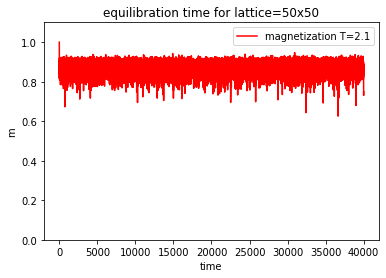

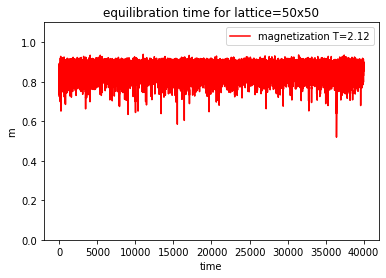

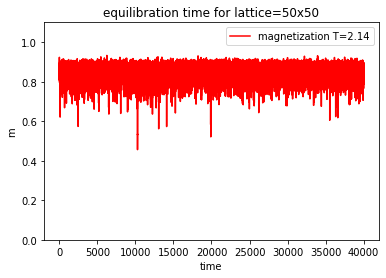

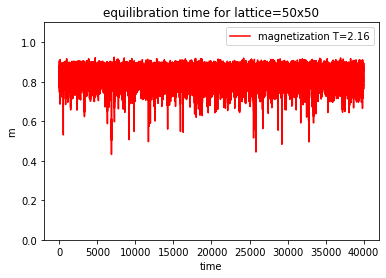

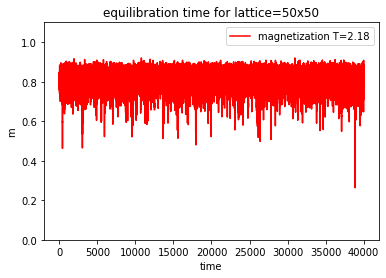

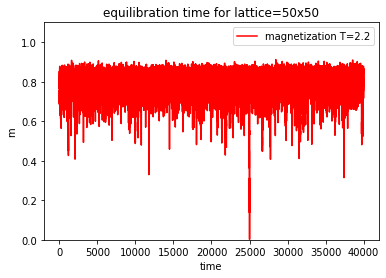

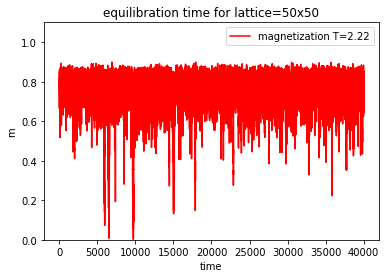

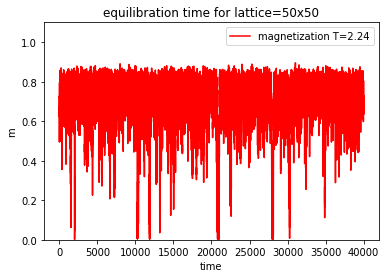

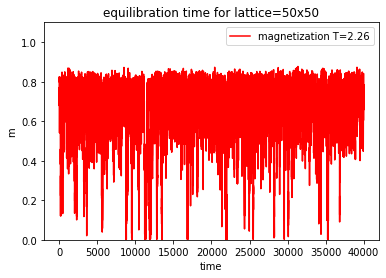

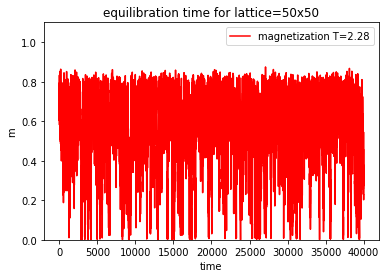

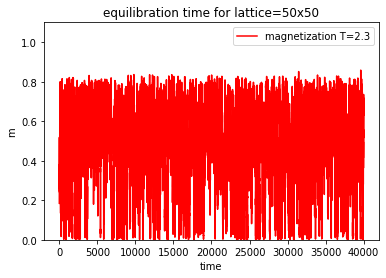

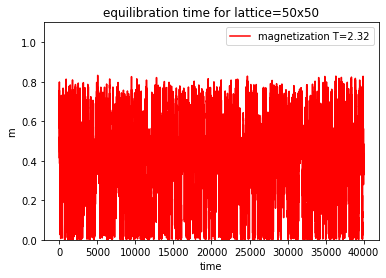

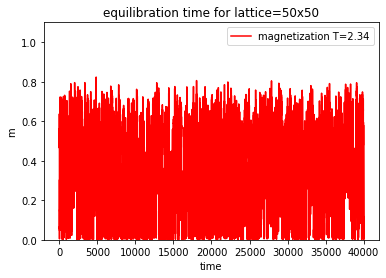

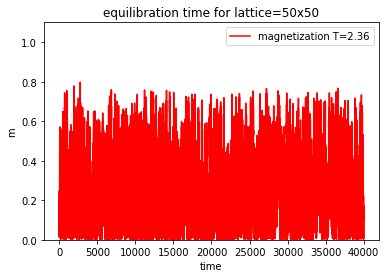

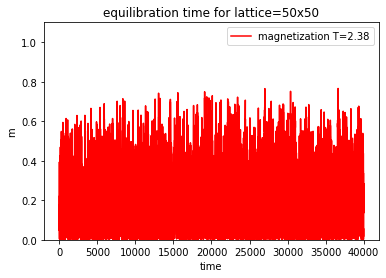

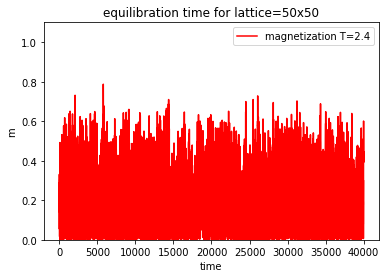

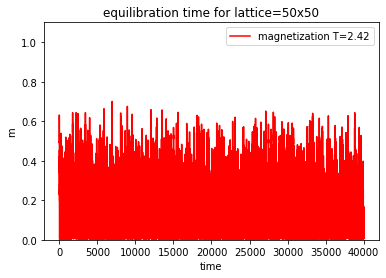

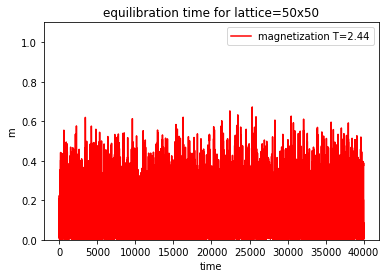

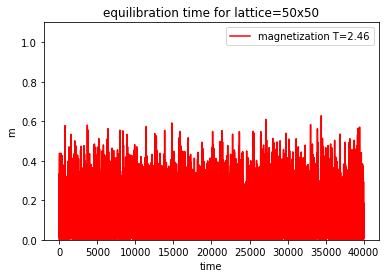

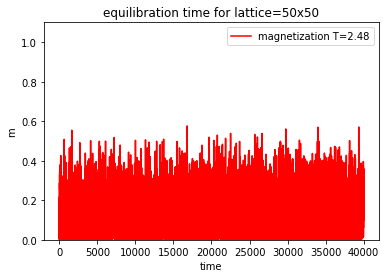

In [0]:
metro50.equilibration()

In [0]:
#save equilibrated data
metro50.lists_after_equilibration(35000) #give input of how many last equilibrated measurements you want to keep

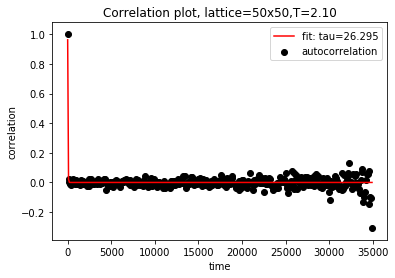

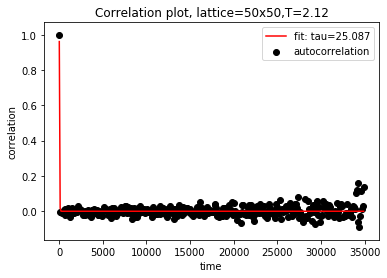

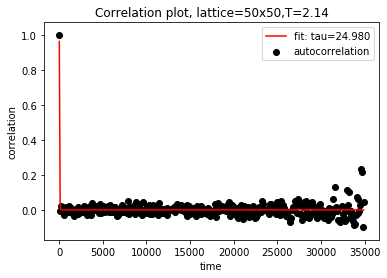

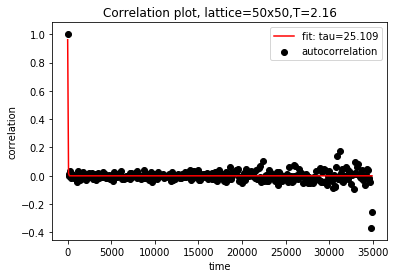

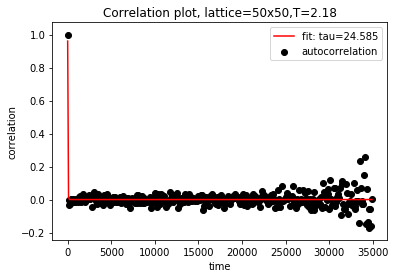

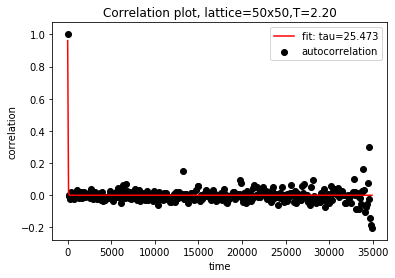

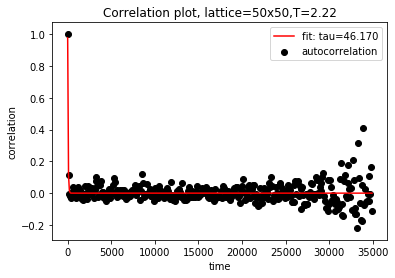

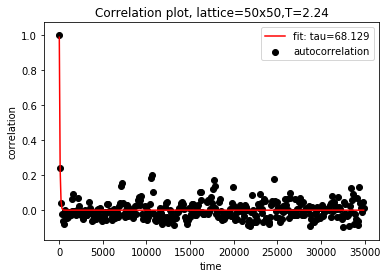

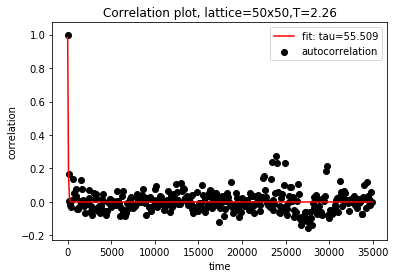

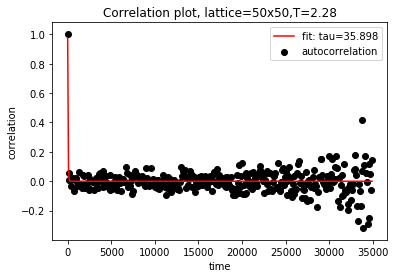

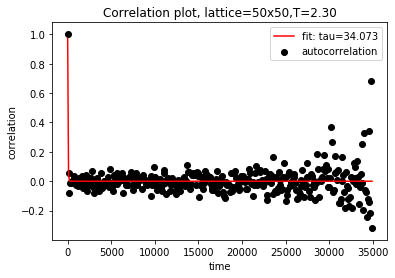

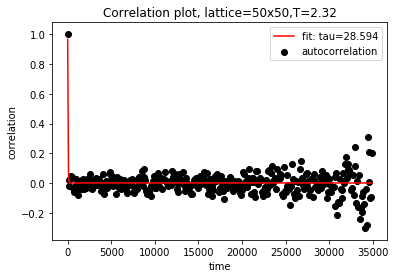

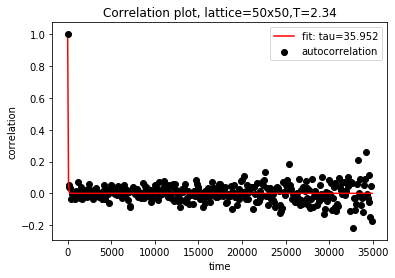

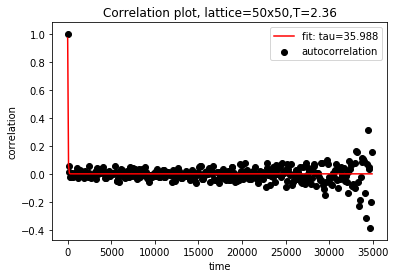

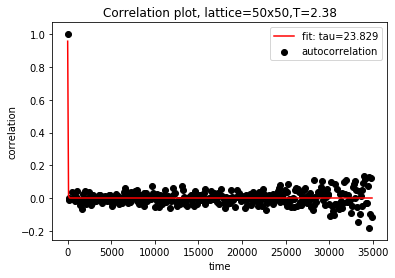

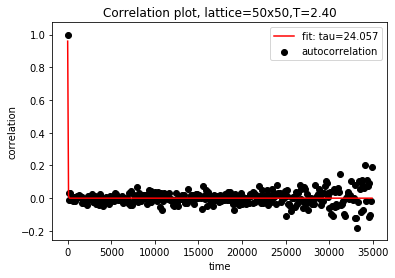

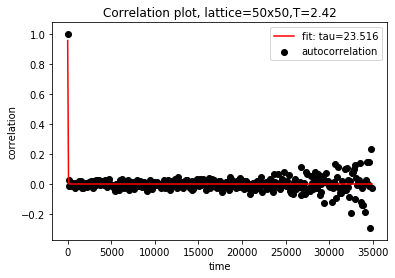

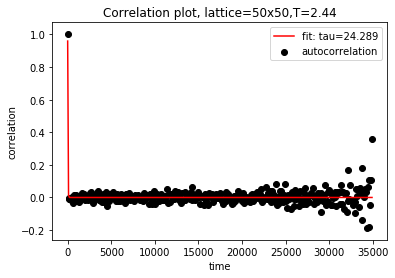

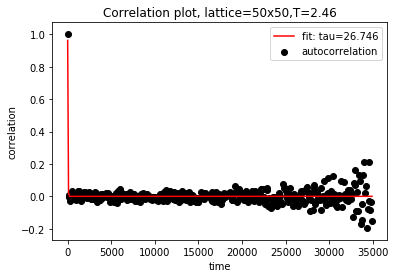

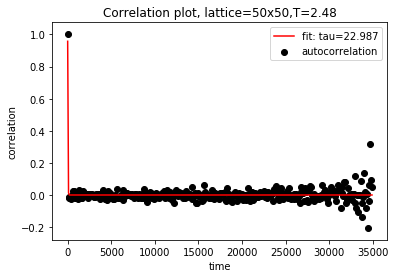

In [0]:
#calculate the correleation time
metro50.plot_correlation(100)  #give the input of the interval after which you want to calculate corr

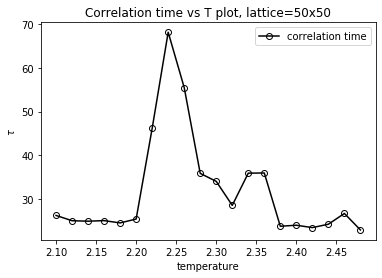

In [0]:
metro50.temp_vs_corr()

In [0]:
# to store the final independent measurements wrt correlation time
metro50.final_measurements()

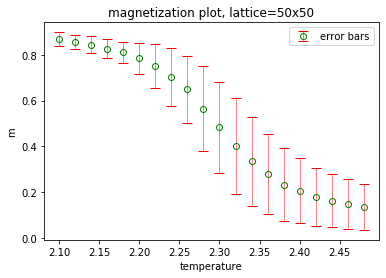

In [0]:
#plotting thermodynamic quantities
metro50.plot_magnetization()

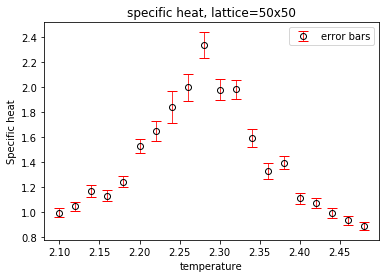

In [0]:
metro50.plot_specific_heat()

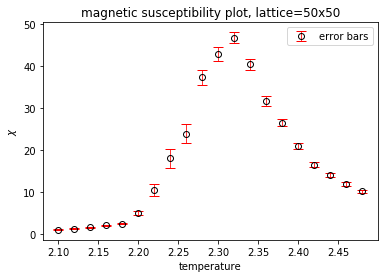

In [0]:
metro50.plot_mag_susceptibility()

In [0]:
# to save this final measurements with errors in a csv file
metro50.save_file()

## L=64

* We will similarly calculate the measurements for lattice size, L=64.
* for L = 64 I have run the algorithm for $2x10^9$ steps for better precision near ctritical region

In [0]:
#uncomment this cell if you want to regenerate the metropolis data 
'''  
N = 64
arr64 = []
temperature = []
l = DefLattice(N)
for T in np.arange(2.1,2.5,0.02):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 2000000000
    l,m,E = metropolis3(N,steps,l,T)
    arr64.append([T,m,E])
np.save('metropolis_data64_short',arr64)
'''and None

In [0]:
m_E_data64 = np.load('metropolis_data64_short.npy',allow_pickle=True)

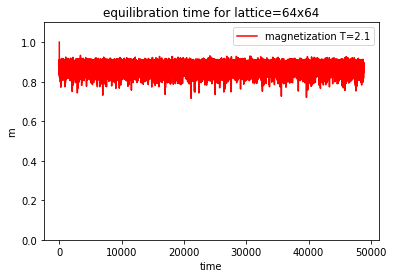

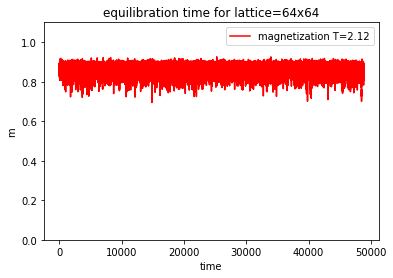

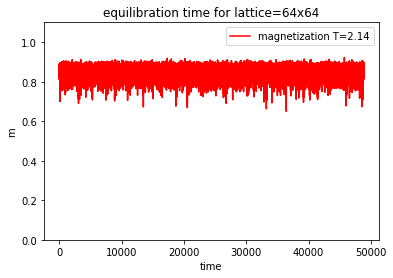

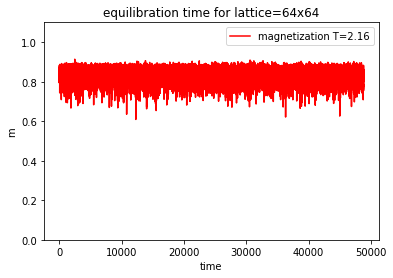

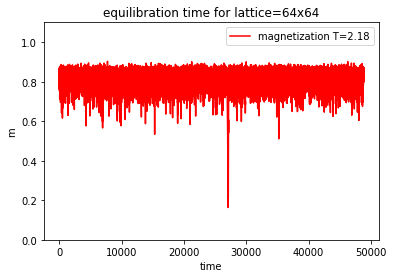

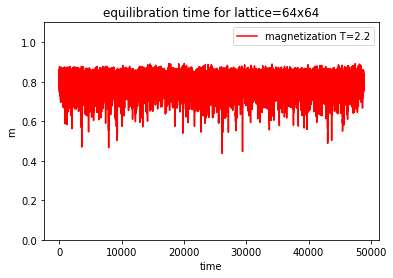

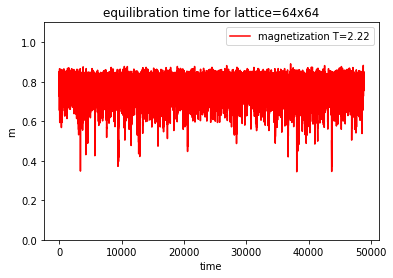

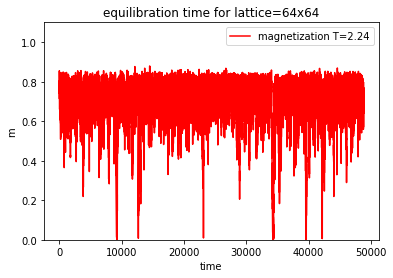

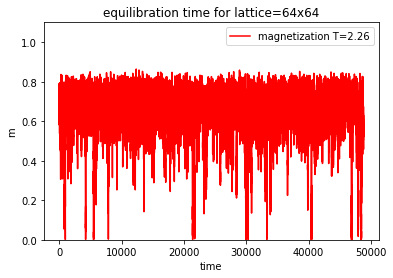

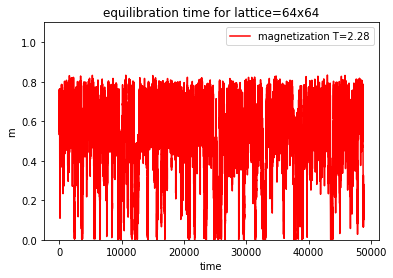

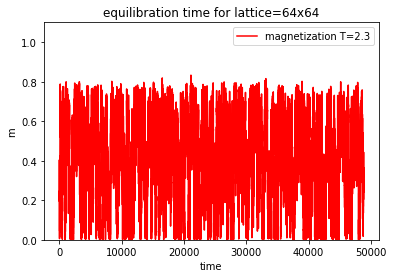

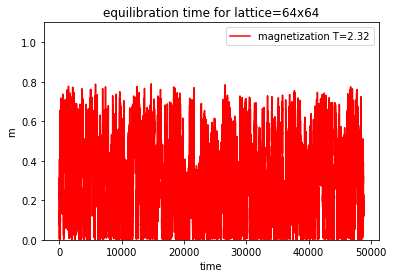

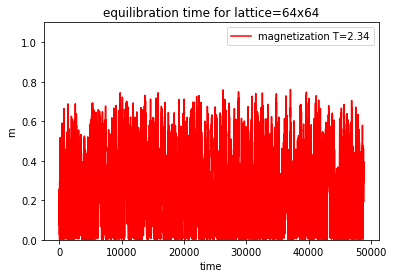

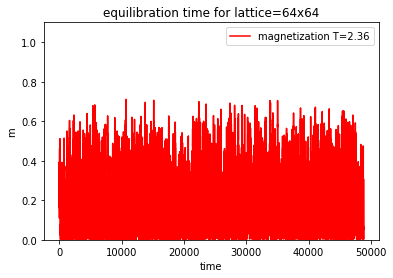

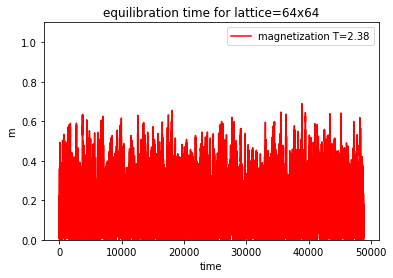

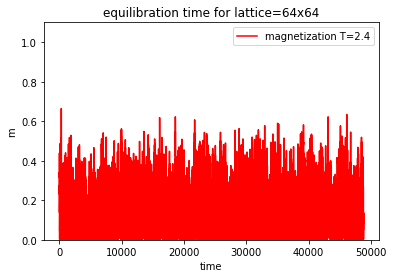

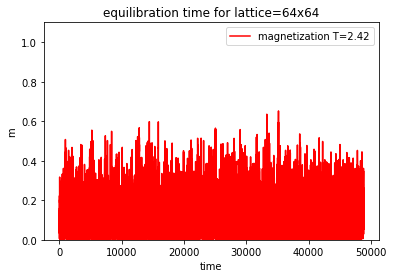

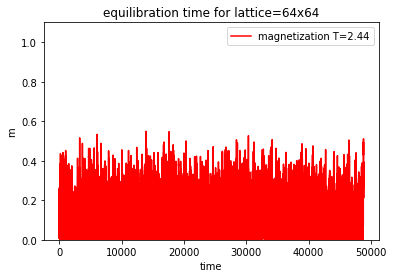

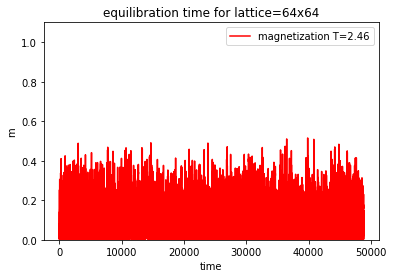

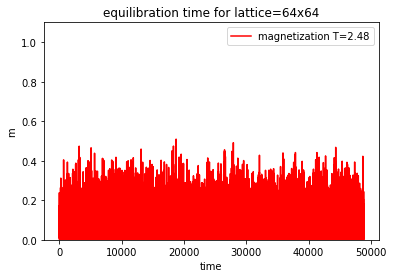

In [0]:
#create an instance of the class for L=50
metro64 = Measurements(64,m_E_data64)  #input N=64 lattice size and metropolis data
metro64.equilibration()

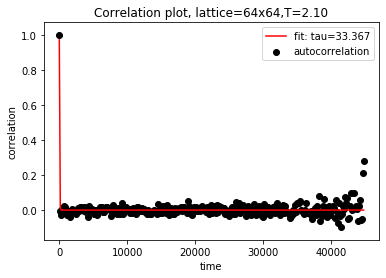

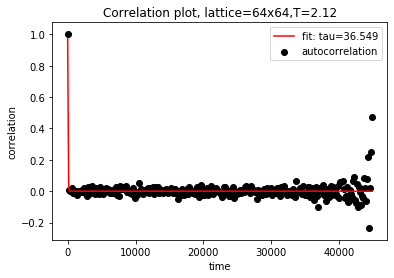

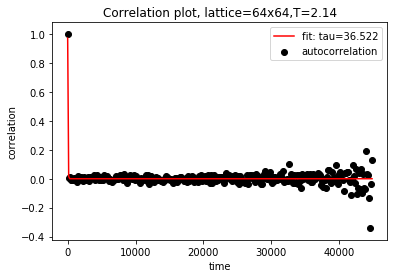

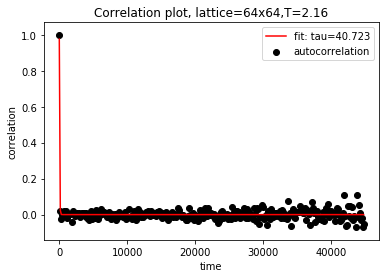

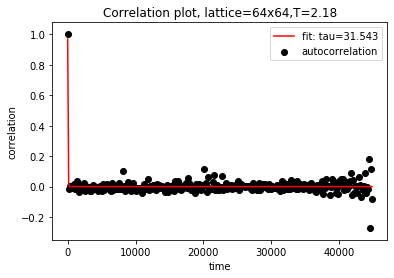

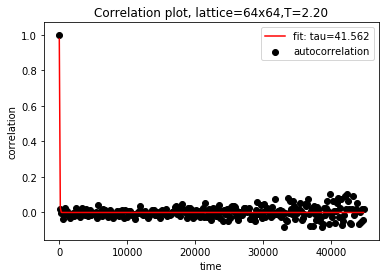

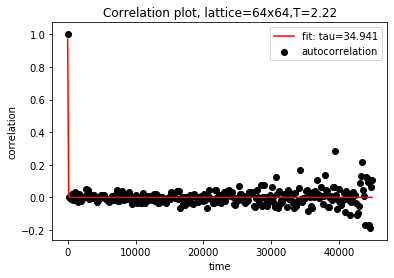

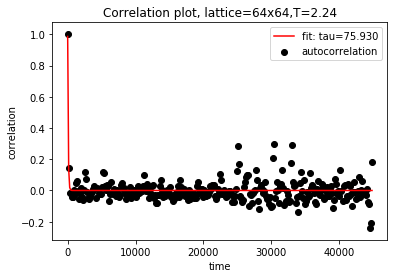

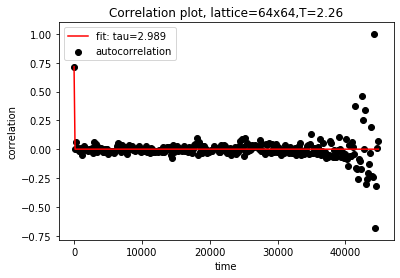

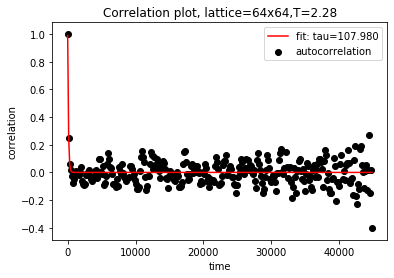

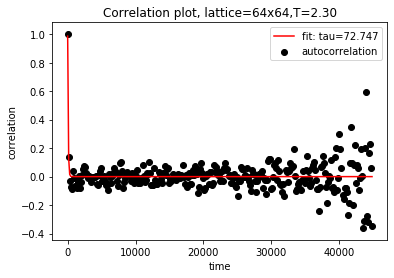

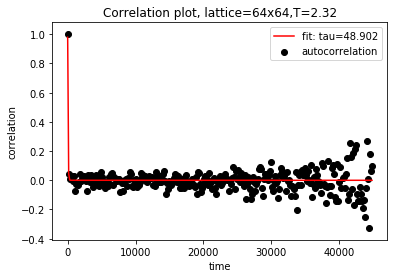

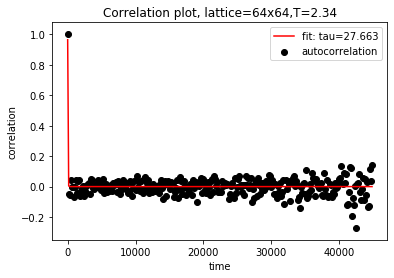

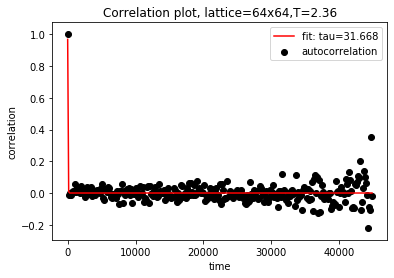

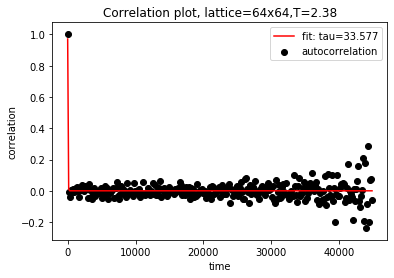

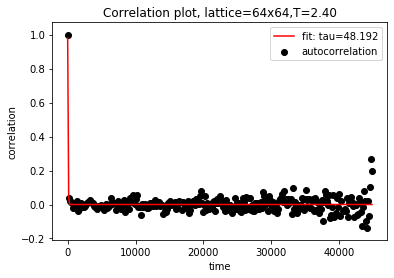

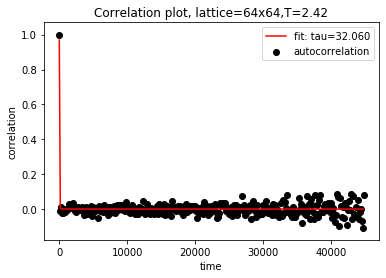

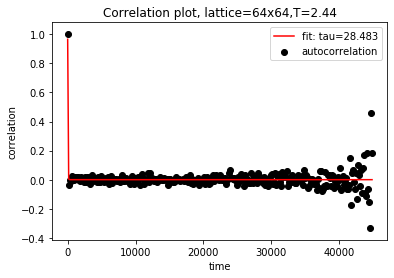

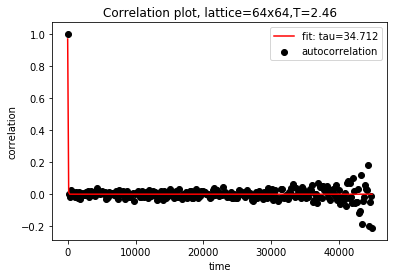

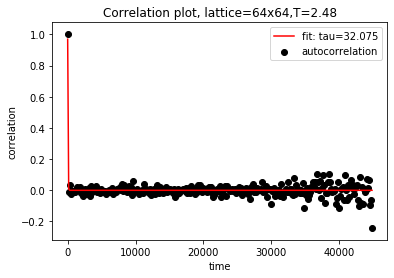

In [0]:
metro64.lists_after_equilibration(45000)
metro64.plot_correlation(150)

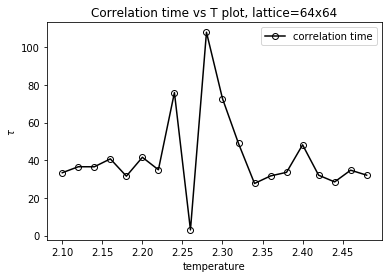

In [0]:
metro64.temp_vs_corr()                #sometimes anamoly can occur because of fitting error

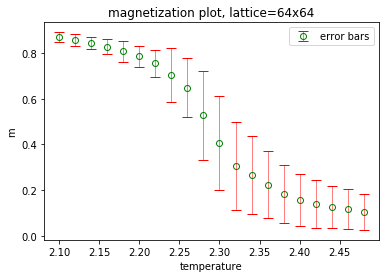

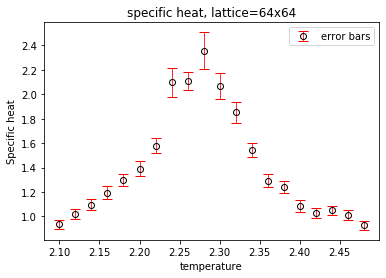

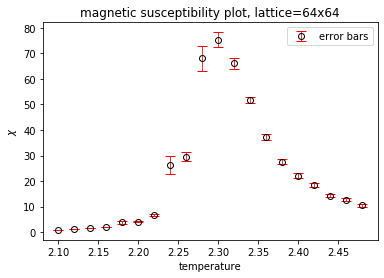

In [0]:
# to store the final independent measurements wrt correlation time
metro64.final_measurements()
metro64.plot_magnetization()
metro64.plot_specific_heat()
metro64.plot_mag_susceptibility()
# to save this final measurements with errors in a csv file
metro64.save_file()

## L=100

* We will similarly calculate the measurements for lattice size, L=100.
* for L = 100 I have run the algorithm for $4x10^9$ steps for better precision near ctritical region

In [0]:
#uncomment this cell if you want to regenerate the metropolis data 
'''  
N = 100
arr100 = []
temperature = []
l = DefLattice(N)
for T in np.arange(2.1,2.5,0.02):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 4000000000
    l,m,E = metropolis3(N,steps,l,T)
    arr100.append([T,m,E])
np.save('metropolis_data100_short',arr100)
'''and None

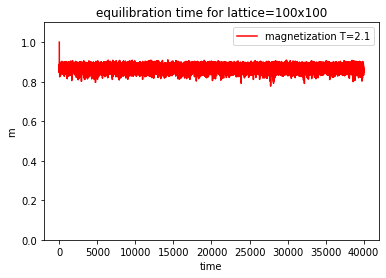

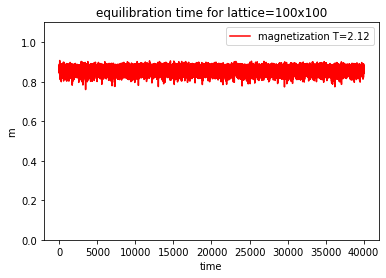

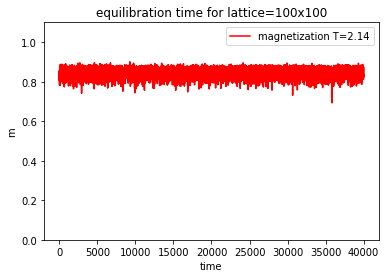

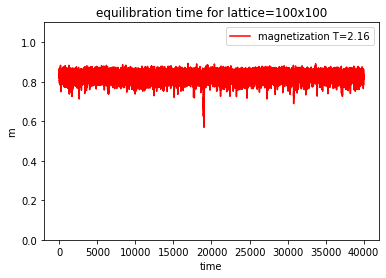

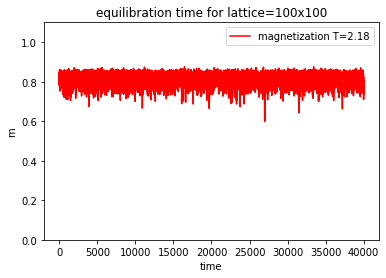

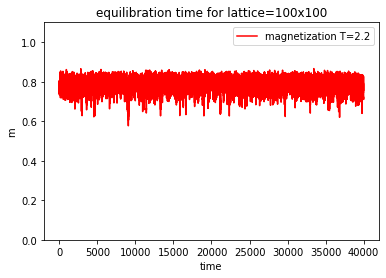

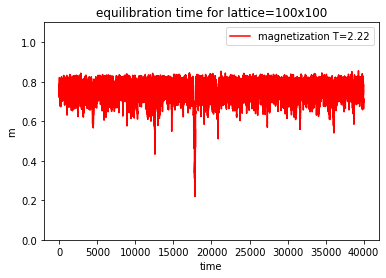

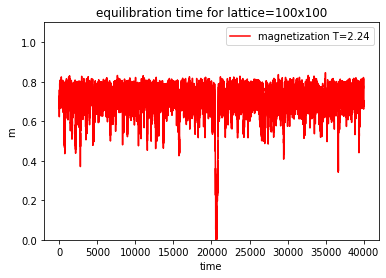

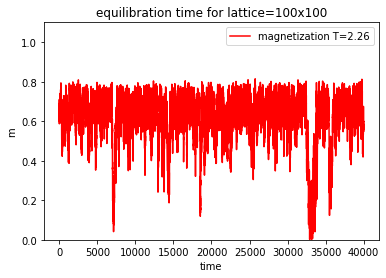

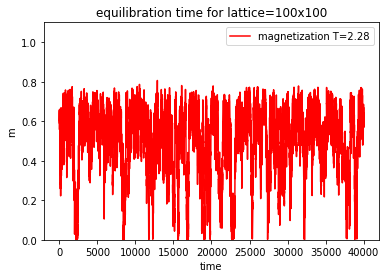

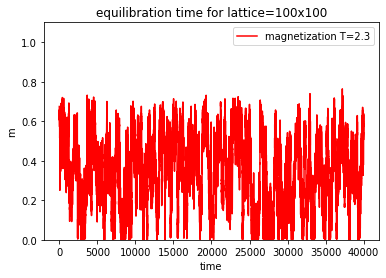

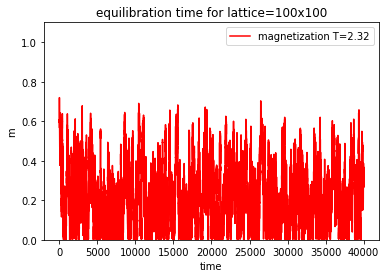

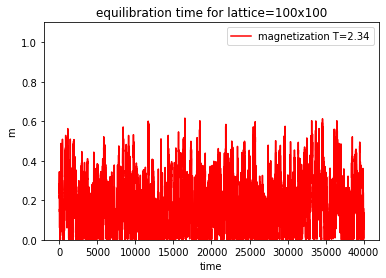

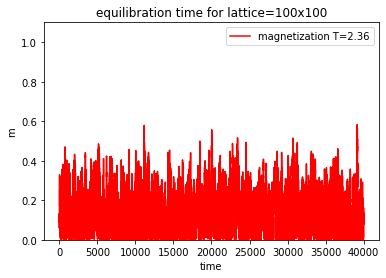

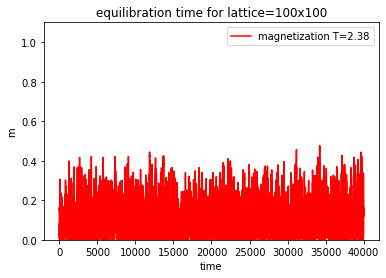

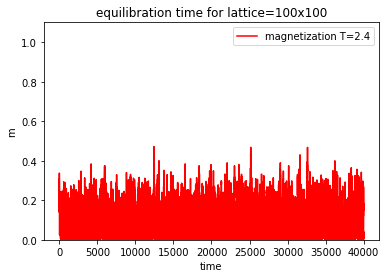

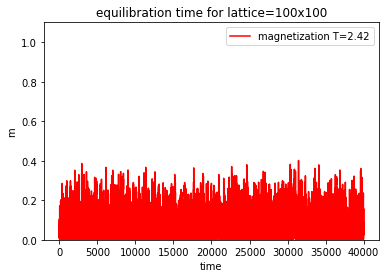

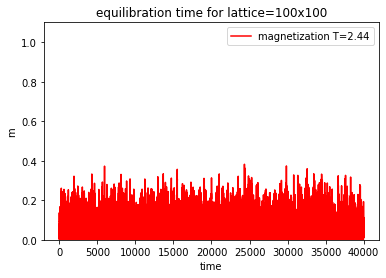

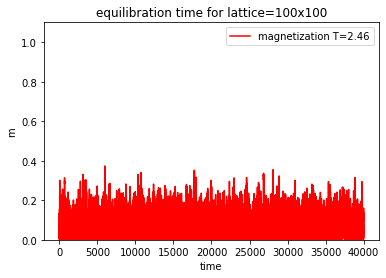

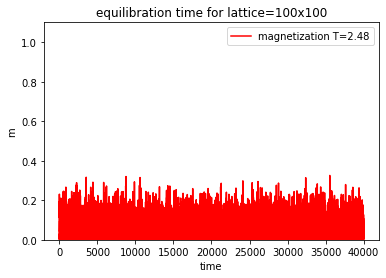

In [0]:
m_E_data100 = np.load('metropolis_data100_short.npy',allow_pickle=True)
metro100 = Measurements(100,m_E_data100)
metro100.equilibration()

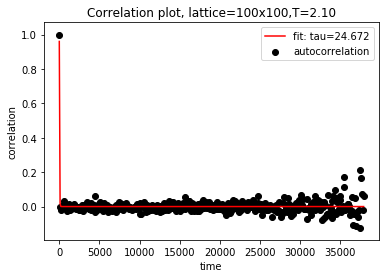

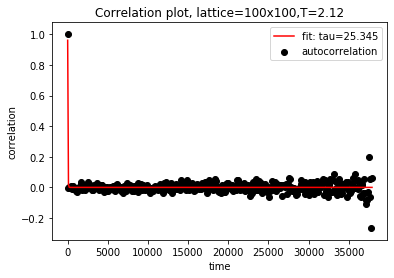

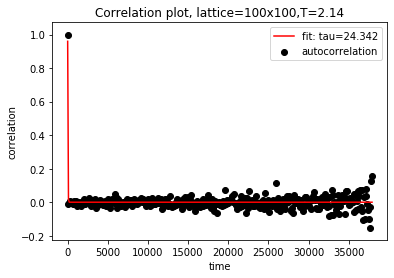

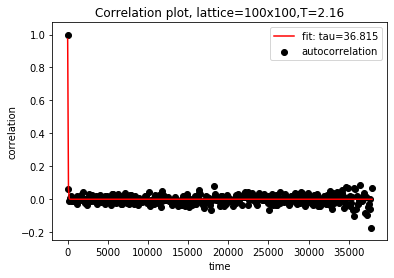

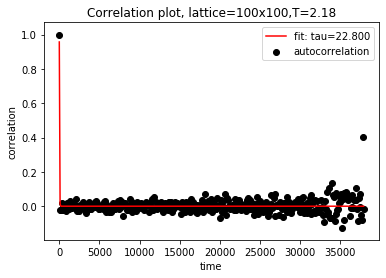

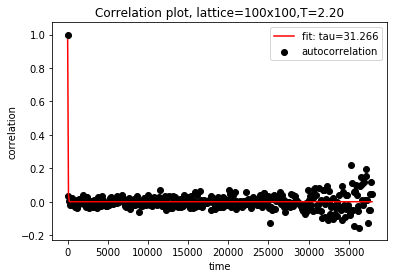

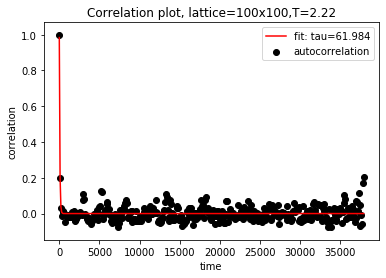

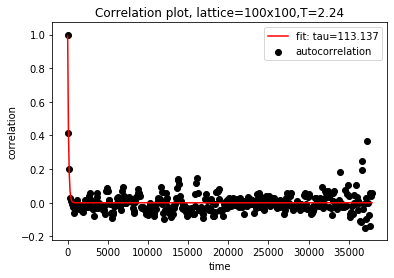

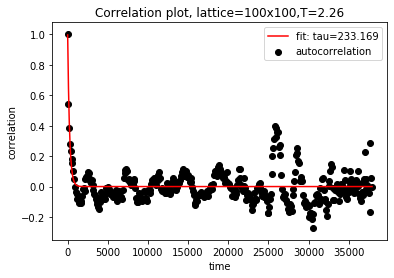

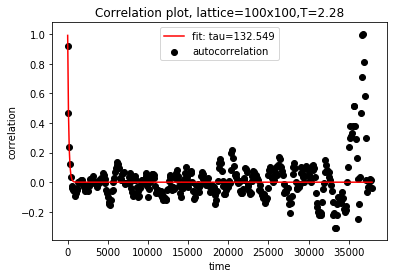

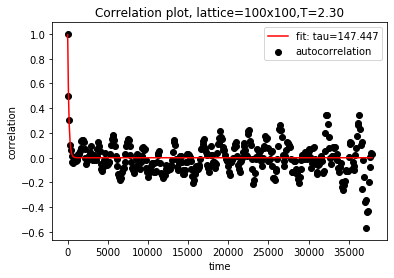

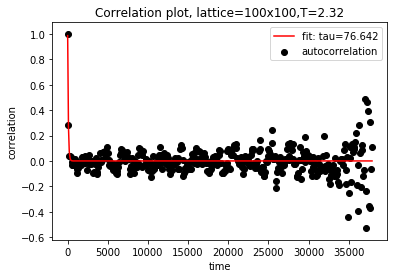

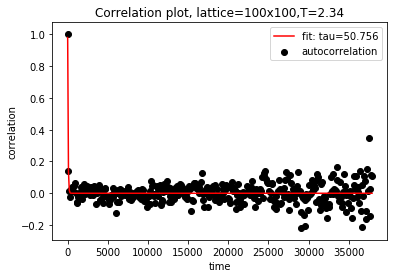

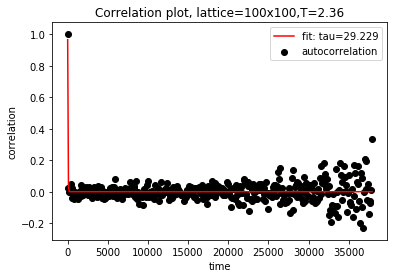

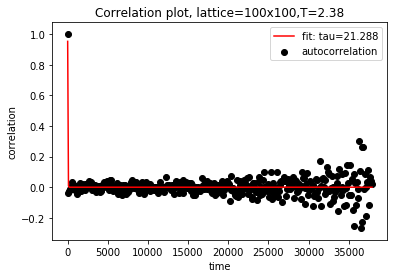

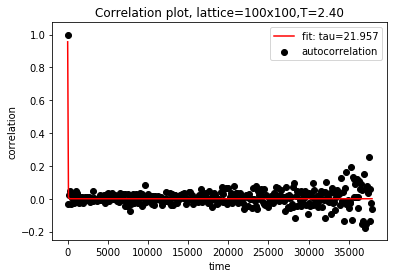

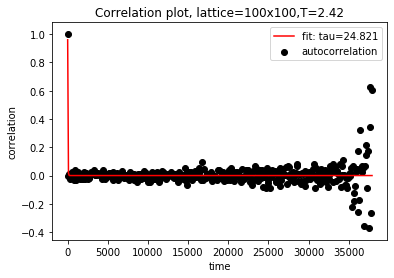

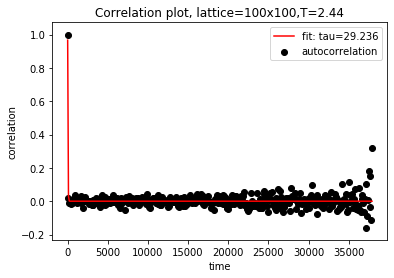

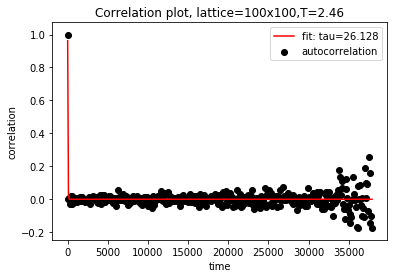

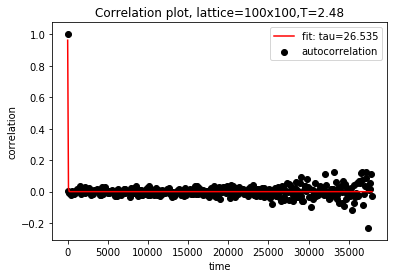

In [0]:
metro100.lists_after_equilibration(38000)
metro100.plot_correlation(100)

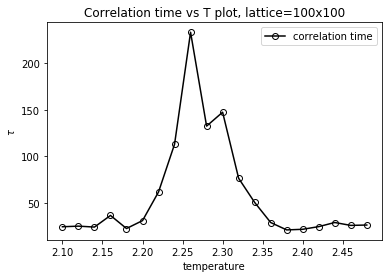

In [0]:
metro100.temp_vs_corr()

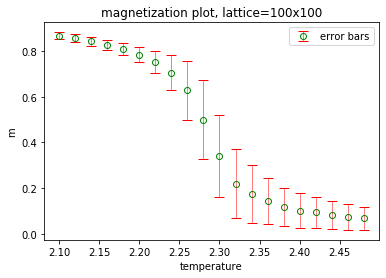

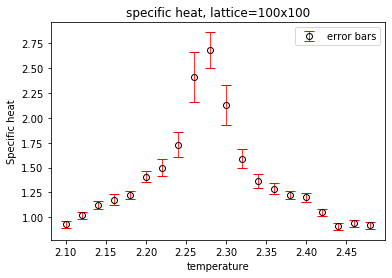

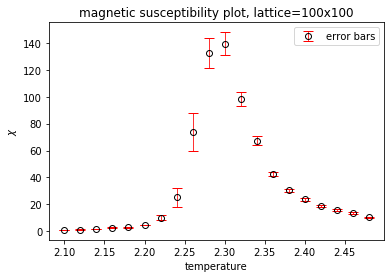

In [0]:
# to store the final independent measurements wrt correlation time
metro100.final_measurements()
metro100.plot_magnetization()
metro100.plot_specific_heat()
metro100.plot_mag_susceptibility()
# to save this final measurements with errors in a csv file
metro100.save_file()

## L=120

* We will similarly calculate the measurements for lattice size, L=120.
* for L = 120 I have run the algorithm for $5x10^9$ steps for better precision near ctritical region.

In [0]:
#uncomment this cell if you want to regenerate the metropolis data 
'''  
N = 120
arr120 = []
temperature = []
l = DefLattice(N)
for T in np.arange(2.1,2.5,0.02):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 5000000000
    l,m,E = metropolis3(N,steps,l,T)
    arr120.append([T,m,E])
np.save('metropolis_data120_short',arr120)
'''and None

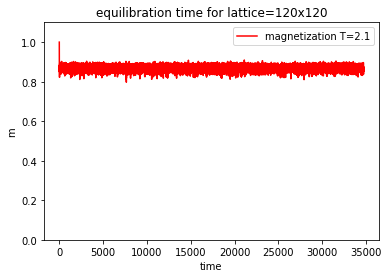

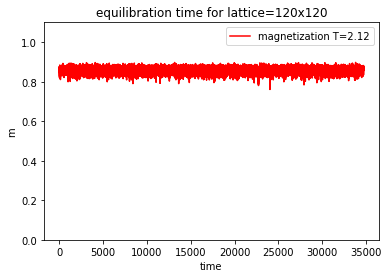

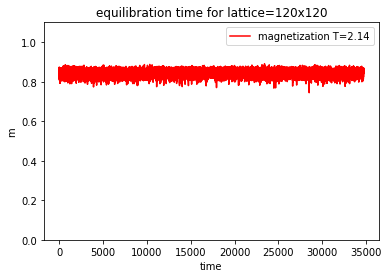

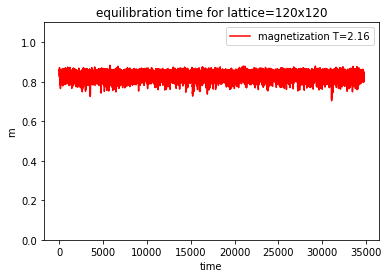

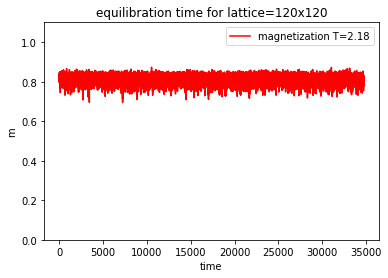

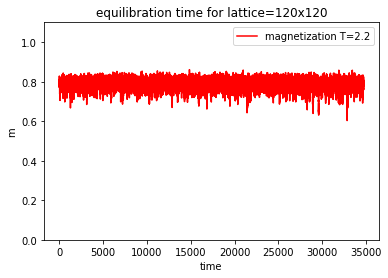

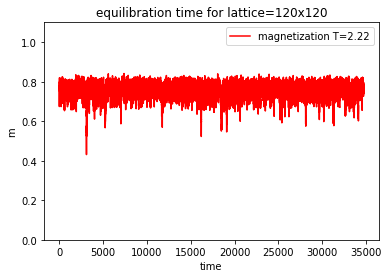

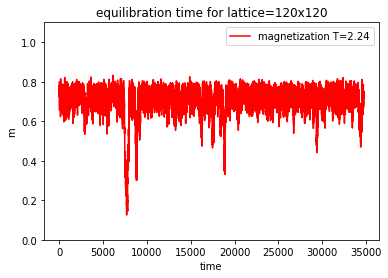

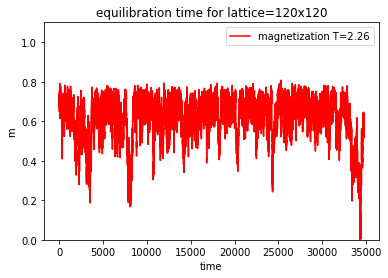

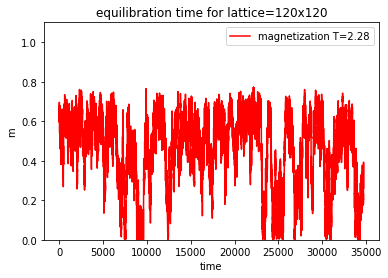

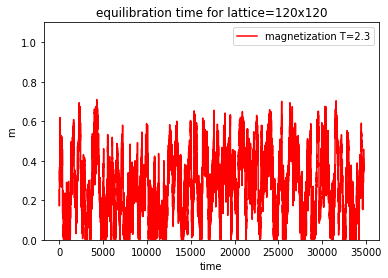

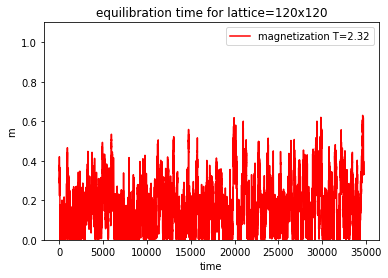

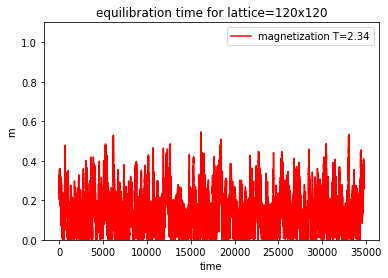

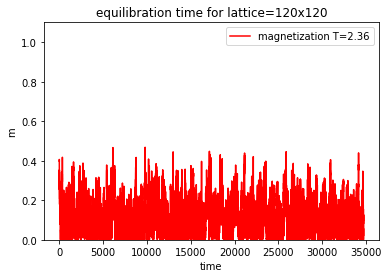

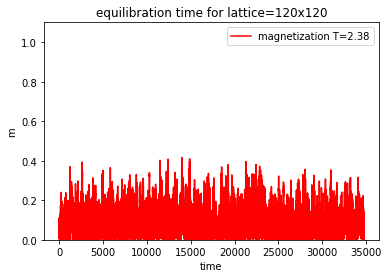

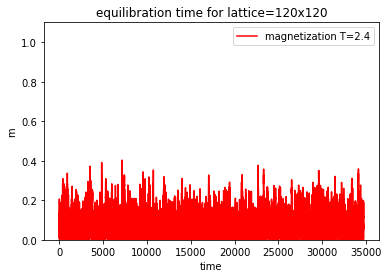

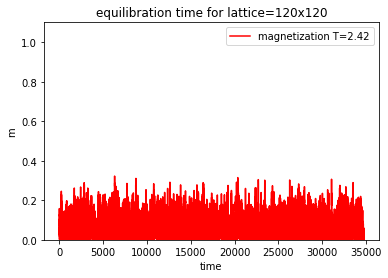

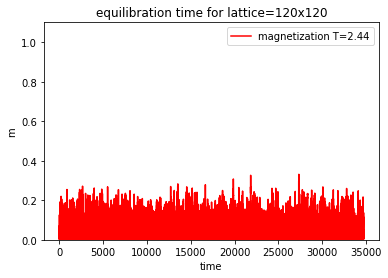

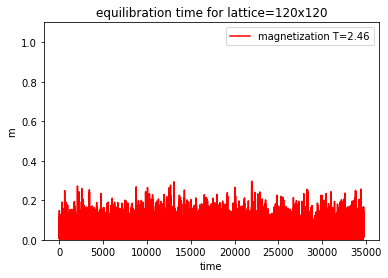

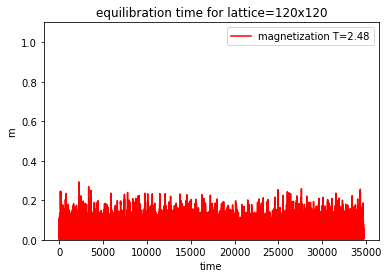

In [0]:
m_E_data120 = np.load('metropolis_data120_short.npy',allow_pickle=True)
metro120 = Measurements(120,m_E_data120)  #N = 120
metro120.equilibration()

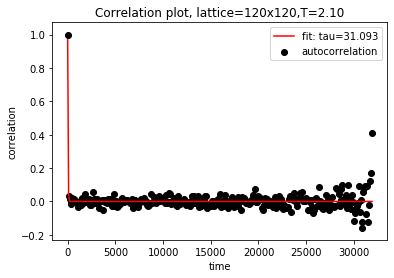

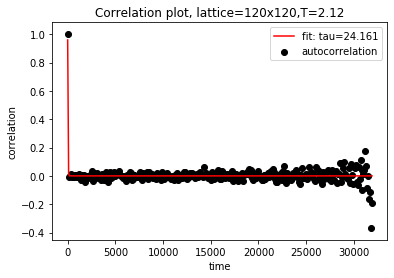

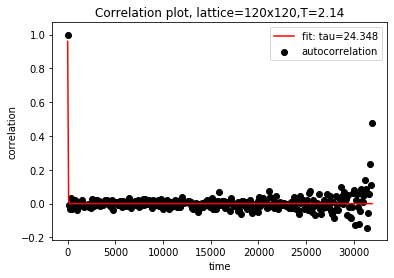

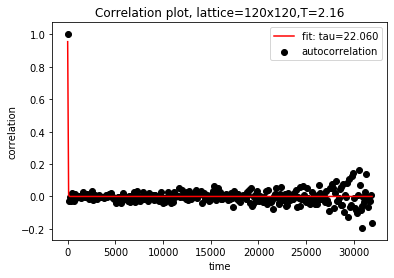

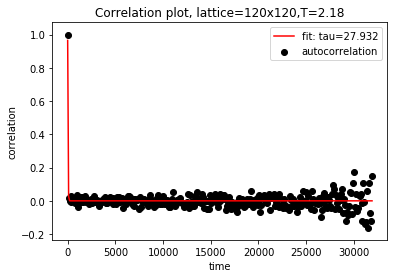

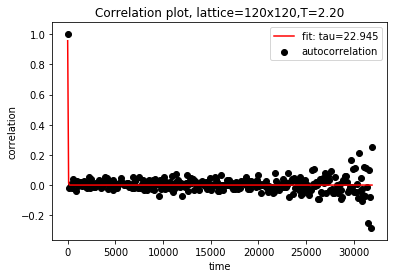

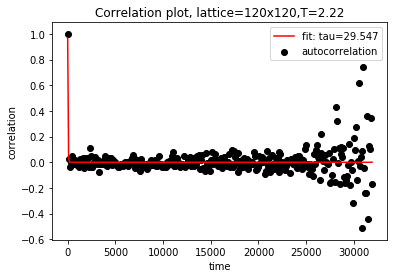

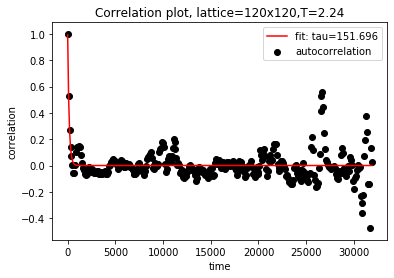

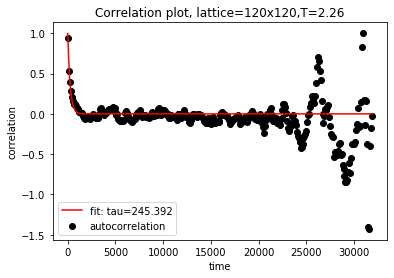

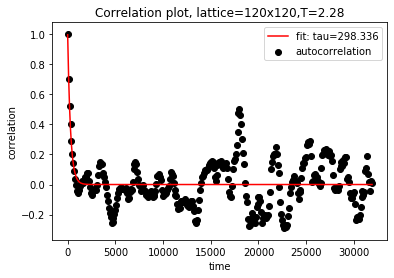

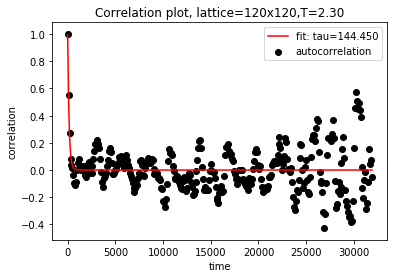

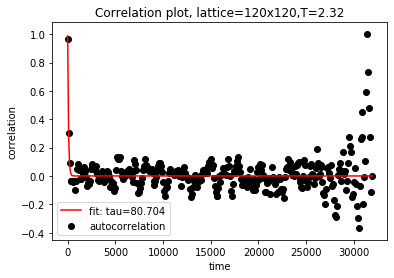

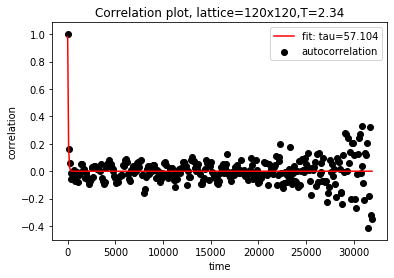

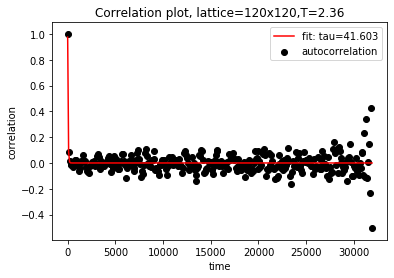

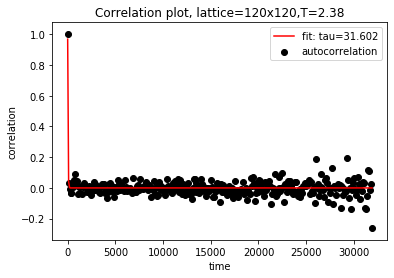

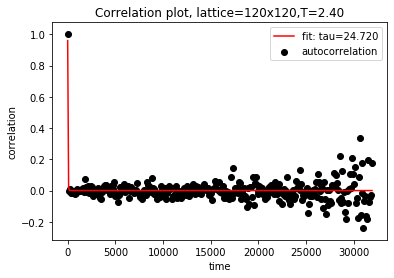

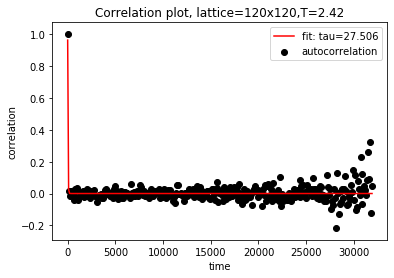

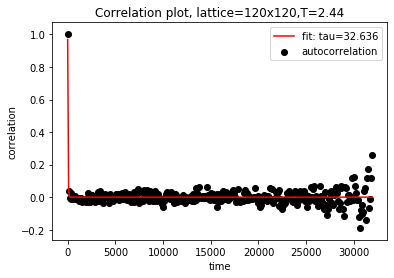

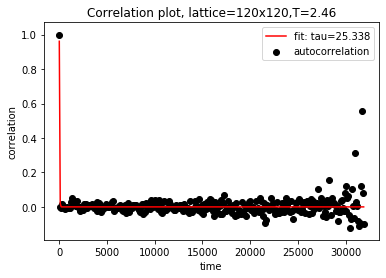

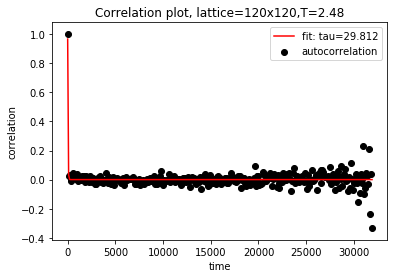

In [0]:
metro120.lists_after_equilibration(32000)
metro120.plot_correlation(100)

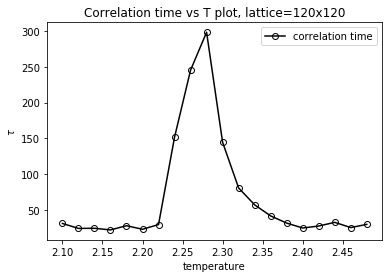

In [0]:
metro120.temp_vs_corr()

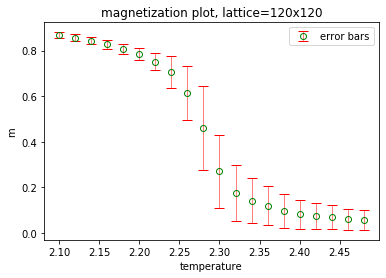

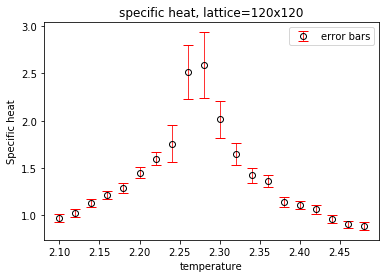

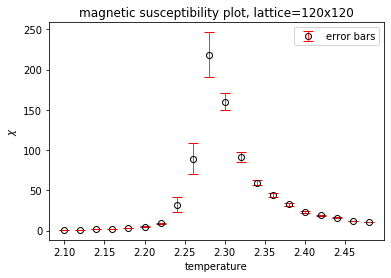

In [0]:
# to store the final independent measurements wrt correlation time
metro120.final_measurements()
metro120.plot_magnetization()
metro120.plot_specific_heat()
metro120.plot_mag_susceptibility()
metro120.save_file()

# 5. Finite size scaling

* In finite size scaling we look at how the thermodynamic quantities vary with size Lof the system.
* FSS is also helpful in giving the estimates of critical exponents.
* we will also try to find the error bars on critical exponents

In [0]:
measure50 = pd.read_csv('measurementsL50.csv')
measure64 = pd.read_csv('measurementsL64.csv')
measure100 = pd.read_csv('measurementsL100.csv')
measure120 = pd.read_csv('measurementsL120.csv')

In [0]:
measure50.head()

temperature  magnetization  mag error  specific heat  sp.heat error  \
0         2.10       0.868745   0.029130       0.997147       0.036979   
1         2.12       0.855135   0.032423       1.048258       0.039055   
2         2.14       0.843809   0.036630       1.171101       0.046776   
3         2.16       0.826548   0.042148       1.134919       0.043536   
4         2.18       0.810270   0.045632       1.246303       0.045506   

   mag susceptibility  suscep error  
0            1.010184      0.062396  
1            1.239693      0.077542  
2            1.567471      0.102289  
3            2.056092      0.134889  
4            2.387945      0.136140

## Critical exponents 

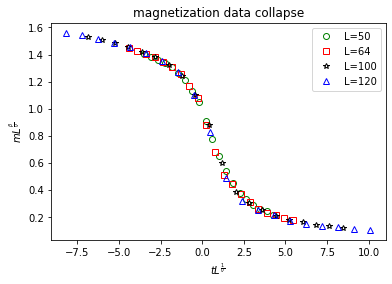

In [0]:
#initial guesses
xc = 2.27
p = 0.125
q = 1.02

temperature = measure50['temperature']
mag50 = measure50['magnetization']
mag64 = measure64['magnetization']
mag100 = measure100['magnetization']
mag120 = measure120['magnetization']

x = [(w-xc)/xc for w in temperature]
t1 = np.array(x)*50**(1/q)
A1 = np.array(mag50)*50**(p/q)

t2 = np.array(x)*64**(1/q)
A2 = np.array(mag64)*64**(p/q)

t3 = np.array(x)*100**(1/q)
A3 = np.array(mag100)*100**(p/q)

t4 = np.array(x)*120**(1/q)
A4 = np.array(mag120)*120**(p/q)

plt.plot(t1,A1,'og',markerfacecolor='none', label='L=50')
plt.plot(t2,A2,'rs',markerfacecolor='none',label='L=64')
plt.plot(t3,A3,'k*',markerfacecolor='none',label='L=100')
plt.plot(t4,A4,'^b',markerfacecolor='none',label='L=120')
plt.legend()

plt.xlabel(r'$t L^\frac{1}{\nu}$')
plt.ylabel(r'$m L^\frac{\beta}{\nu}$')
plt.title('magnetization data collapse')
plt.show()

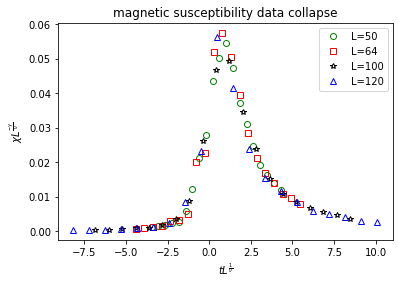

In [0]:
xc = 2.27
p = 1.76
q = 1.02

temperature = measure50['temperature']
magsuscep50 = measure50['mag susceptibility']
magsuscep64 = measure64['mag susceptibility']
magsuscep100 = measure100['mag susceptibility']
magsuscep120 = measure120['mag susceptibility']


x = [(w-xc)/xc for w in temperature]
t1 = np.array(x)*50**(1/q)
A1 = np.array(magsuscep50)*50**(-p/q)

t2 = np.array(x)*64**(1/q)
A2 = np.array(magsuscep64)*64**(-p/q)

t3 = np.array(x)*100**(1/q)
A3 = np.array(magsuscep100)*100**(-p/q)

t4 = np.array(x)*120**(1/q)
A4 = np.array(magsuscep120)*120**(-p/q)



plt.plot(t1,A1,'og',markerfacecolor='none',label='L=50')
plt.plot(t2,A2,'rs',markerfacecolor='none',label='L=64')
plt.plot(t3,A3,'k*',markerfacecolor='none',label='L=100')
plt.plot(t4,A4,'^b',markerfacecolor='none',label='L=120')


plt.xlabel(r'$t L^\frac{1}{\nu}$')
plt.ylabel(r'$\chi L^\frac{-\gamma}{\nu}$')
plt.legend()
plt.title('magnetic susceptibility data collapse')
plt.show()

## Errors on critical exponents

In [0]:
#least square error method
def errors(x,y):
    N = len(x)
    sxx = sum([i**2 for i in x])
    syy = sum([i**2 for i in y])
    sx = sum(x)
    sy = sum(y)
    sxy = sum(np.multiply(x,y))
    delta = N*sxx - sx**2
    m = (N*sxy - sx*sy)/delta
    c = (sxx*sy - sx*sxy)/delta
    sigma = []
    for i in range(len(x)):
        z = (y[i] - m*x[i] - c)**2
        sigma.append(z)
    #sigmay = sqrt(sum(sigma)/(N-2))
    #print(sigmay)
    sigmay = 0.1
    sigmac = sigmay*np.sqrt(sxx/delta)
    sigmam = sigmay*np.sqrt(N/delta)
    ans = []
    ans.append(m)
    ans.append(c)
    ans.append(sigmam)
    ans.append(sigmac)
    return ans

 plotting $T_0$ against $L^{-1/\nu}$

[2.7223699202430964, 2.26327636409672, 10.801527511507157, 0.15404821325345888]


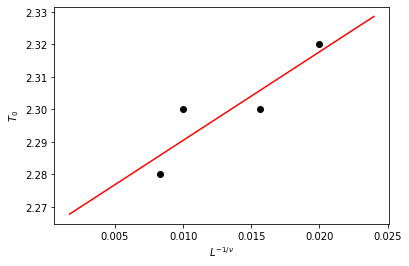

In [0]:
magsuscep50 = measure50['mag susceptibility']
magsuscep64 = measure64['mag susceptibility']
magsuscep100 = measure100['mag susceptibility']
magsuscep120 = measure120['mag susceptibility']

xc = 2.27
p = 1.76
q = 1.0

x = [(w-xc)/xc for w in temperature]
t1 = np.array(x)*50**(1/q)
A1 = np.array(magsuscep50)*50**(-p/q)

t2 = np.array(x)*64**(1/q)
A2 = np.array(magsuscep64)*64**(-p/q)

t3 = np.array(x)*100**(1/q)
A3 = np.array(magsuscep100)*100**(-p/q)

t4 = np.array(x)*120**(1/q)
A4 = np.array(magsuscep120)*120**(-p/q)


x01 = t1[list(A1).index(max(A1))]
x02 = t2[list(A2).index(max(A2))]
x03 = t3[list(A3).index(max(A3))]
x04 = t4[list(A4).index(max(A4))]

t01 = xc*(1+x01*50**(-1/q))
t02 = xc*(1+x02*64**(-1/q))
t03 = xc*(1+x03*100**(-1/q))
t04 = xc*(1+x04*120**(-1/q))

T0 = [t01,t02,t03,t04]
Lnu = [50**(-1/q),64**(-1/q),100**(-1/q),120**(-1/q)]


fit = errors(Lnu,T0)
print(fit)  #gives m,c,deltam,deltac as output
t = np.linspace(min(Lnu)*0.2,max(Lnu)*1.2,10)
y = fit[0]*t + fit[1]
plt.plot(t,y,color='red')
plt.scatter(Lnu,T0,color='black')
#plt.errorbar(Lnu,T0,yerr=0.01,fmt='ok',capsize=5)
plt.xlabel(r'$L^{-1/\nu}$')
plt.ylabel(r'$T_0$')
plt.show()

* We can fiddle the initial guesses to minimize the error and apply bootstrap or jakknife to calculate the error on $\nu$. This part is easier to do manually than writing a code. 

plotting, $ \chi_L (T_0) \propto L^{\gamma/\nu}$ 

log(L) against log($\chi$)

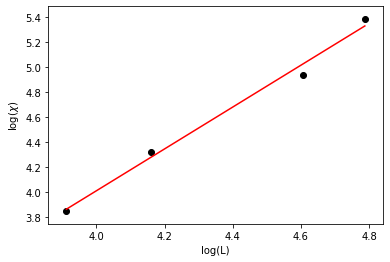

In [0]:
chi1 = max(magsuscep50)
chi2 = max(magsuscep64)
chi3 = max(magsuscep100)
chi4 = max(magsuscep120)


chi = [chi1,chi2,chi3,chi4]
logchi = [np.log(i) for i in chi]

L = [50,64,100,120]
logL = [np.log(i) for i in L]
fit = errors(logL,logchi)
t = np.linspace(min(logL),max(logL),100)
y = fit[0]*t + fit[1]
plt.plot(t,y,color='red')
plt.scatter(logL,logchi,color='black')
#plt.errorbar(logL,logchi,yerr=0.14,fmt='ok')
plt.xlabel('log(L)')
plt.ylabel(r'log($\chi$)')
plt.show()

# 6. Tackling the problem of critical slow down with Wolff's Algorithm

In [0]:
def neighbour_sites(x,y,N):
    neighbours = {(x,y):  [((x + 1) % N,y),((x - 1 + N) % N,y),(x,(y + 1) % N),(x,(y - 1 + N) % N)]}
    return neighbours
                      
def wolff_algorithm(N,steps,lattice,T):
    E = TotalEnergy(lattice,N)
    M = TotalMagnetisation(lattice)
    Elist = []         #to store Energy at each time
    mlist = []         #to store Magnetization at each time
    p_add =  1.0 - np.exp(-2.0 / T)
    for step in range(steps):
        x = random.randrange(N)    #to generate random x cordinate
        y = random.randrange(N)    #to generate random y cordinate
        boundary_spins, Cluster = [(x,y)], [(x,y)]
        while boundary_spins != []:
            j = random.choice(boundary_spins)
            neighbours = neighbour_sites(*j,N)
            for l in neighbours[j]:
                if lattice[l] == lattice[j] and l not in Cluster and random.uniform(0.0, 1.0) < p_add:
                    boundary_spins.append(l)
                    Cluster.append(l)
            boundary_spins.remove(j)
        for j in Cluster:
            lattice[j] *= -1
        E = TotalEnergy(lattice,N)
        M = TotalMagnetisation(lattice)
        Elist.append(E) #appending energy per site
        mlist.append(abs(M/(N*N))) #appending magnetization per site
    return lattice,mlist,Elist
        


## L = 50

In [0]:
''' 
N = 50
lat = DefLattice(N)
arr50 = []
temperature = []
l = DefLattice(N)
for T in np.arange(2.1,2.5,0.02):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 1000
    l,m,E = wolff_algorithm(N,steps,l,T)
    arr50.append([T,m,E])
np.save('wolff_dataL50',arr50)
'''and None

In [0]:
m_E_data50 = np.load('wolff_dataL50.npy',allow_pickle=True)

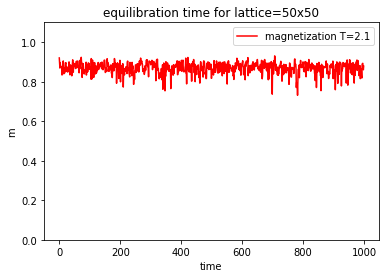

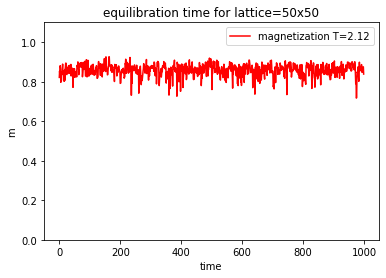

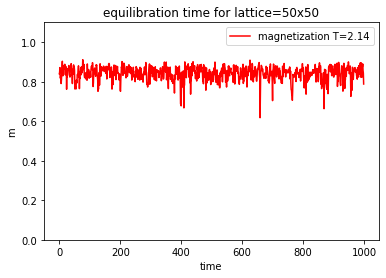

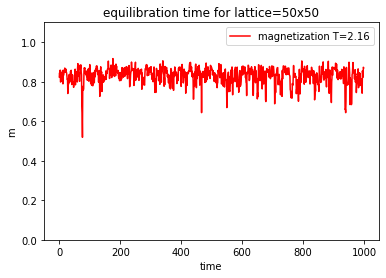

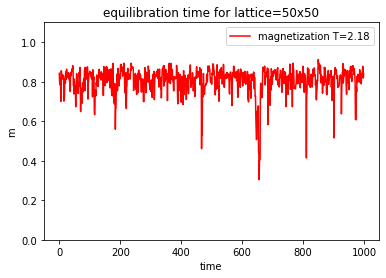

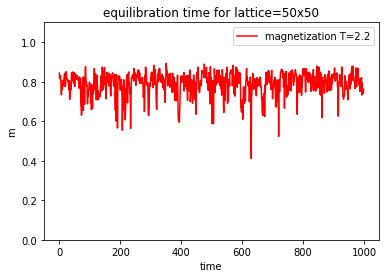

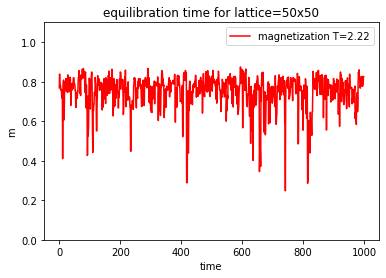

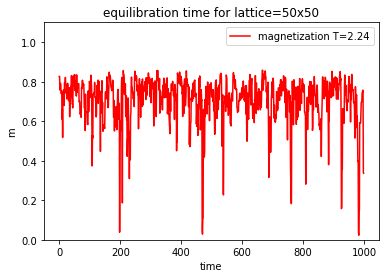

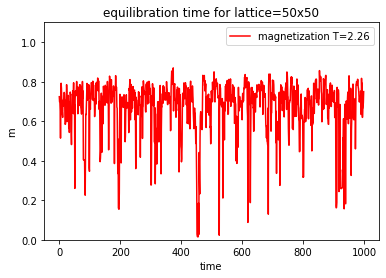

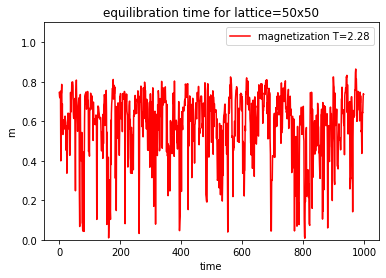

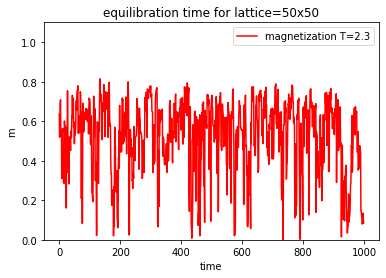

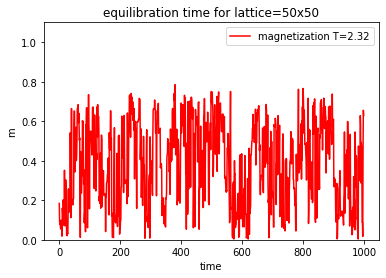

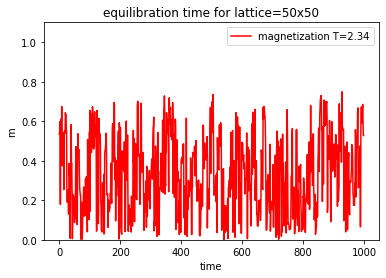

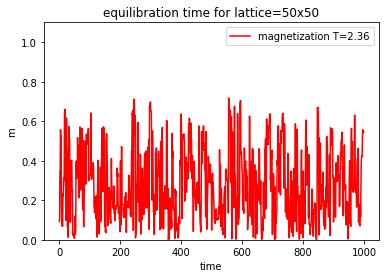

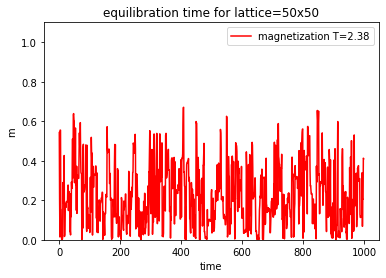

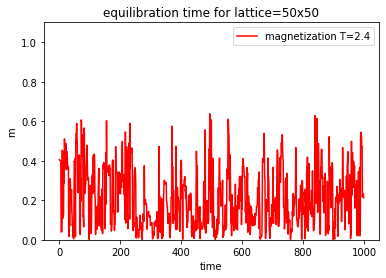

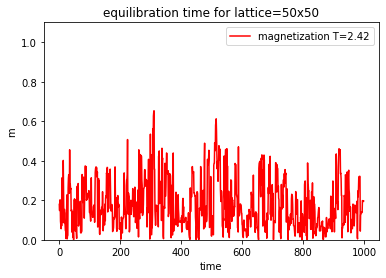

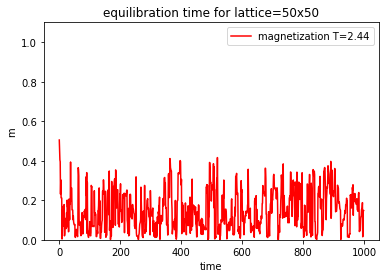

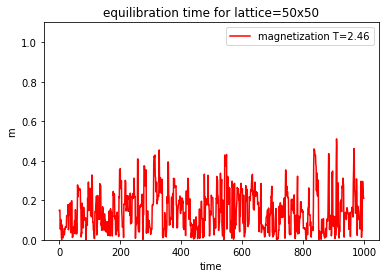

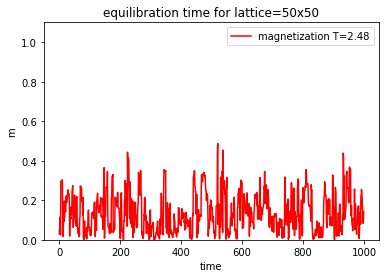

In [0]:
wolff50 = Measurements(50,m_E_data50)
wolff50.equilibration()

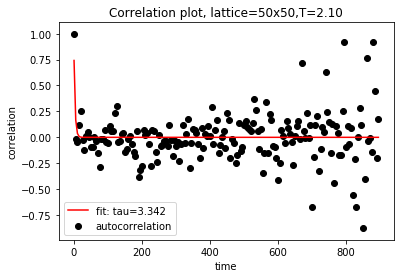

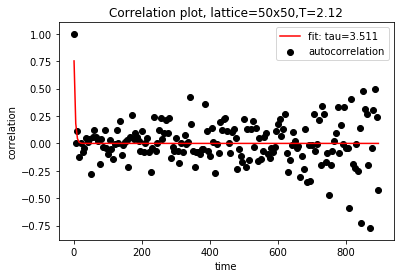

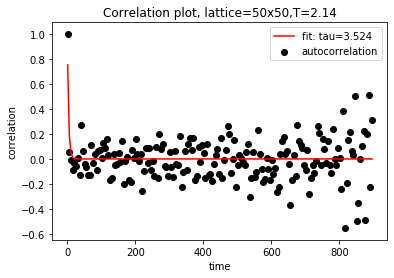

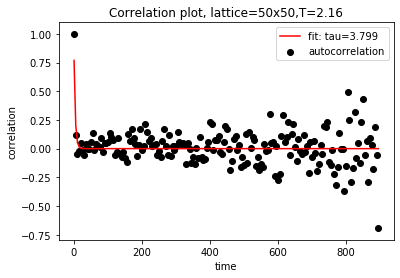

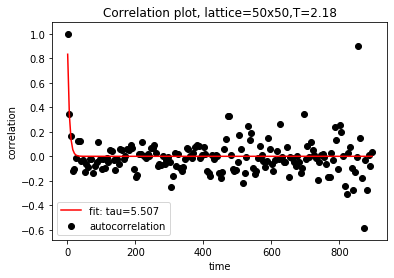

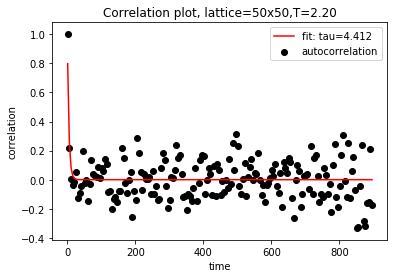

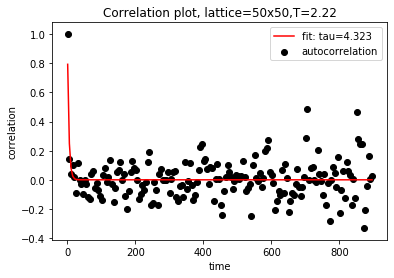

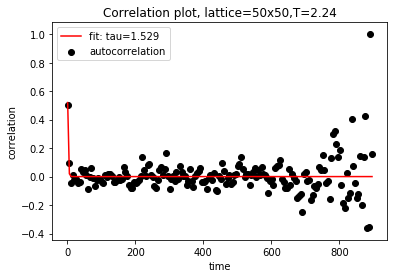

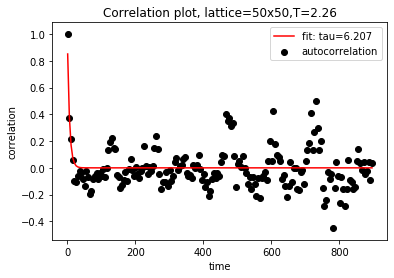

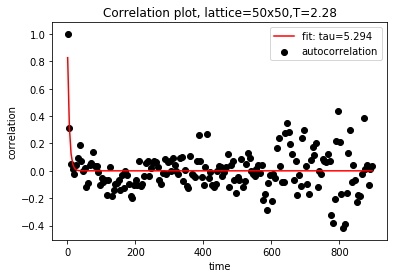

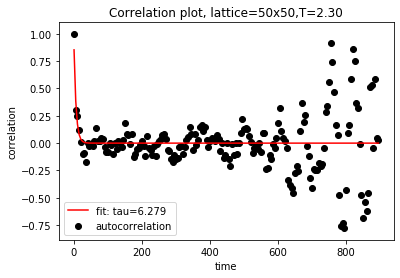

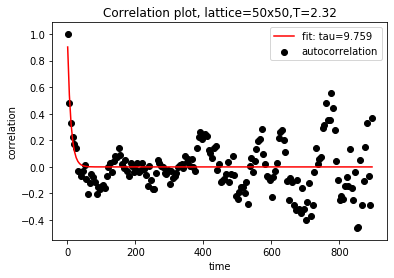

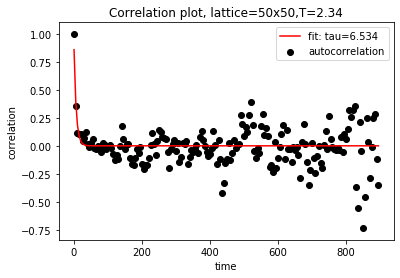

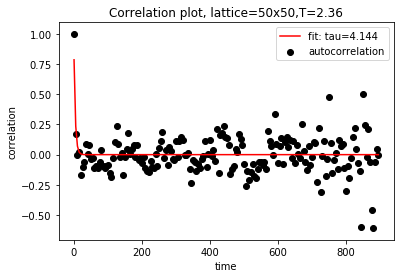

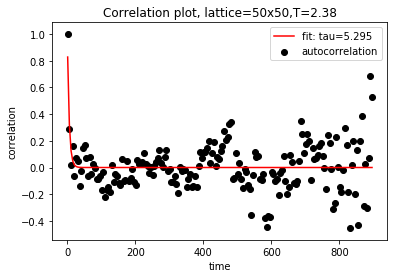

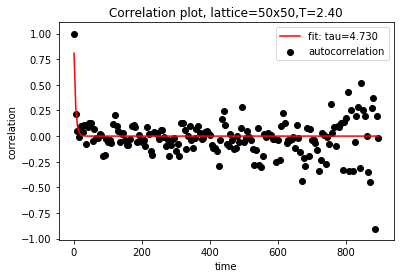

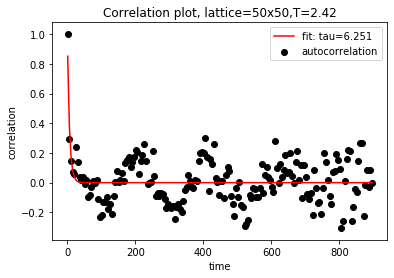

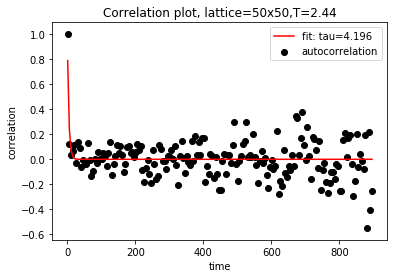

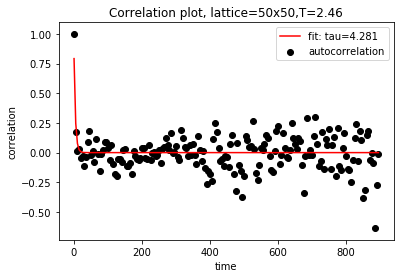

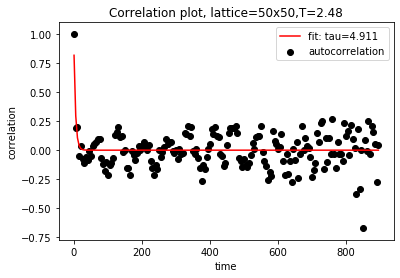

In [0]:
wolff50.lists_after_equilibration(900)
wolff50.plot_correlation(5)

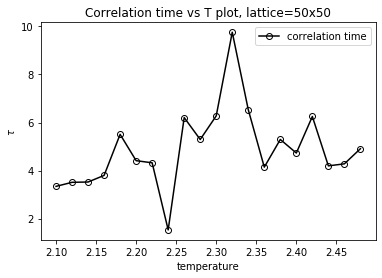

In [0]:
wolff50.temp_vs_corr()

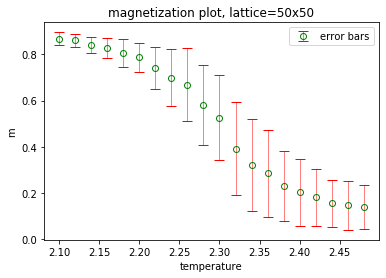

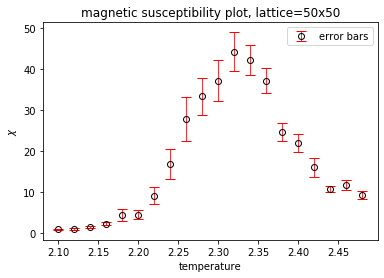

In [0]:
wolff50.final_measurements_wolff()
wolff50.plot_magnetization()
wolff50.plot_mag_susceptibility()

## L = 64

In [0]:
''' 
N = 64
lat = DefLattice(N)
arr64 = []
temperature = []
l = DefLattice(N)
for T in np.arange(2.1,2.5,0.02):
    T = float(str('%.2f'%T))
    temperature.append(T)
    steps = 1000
    l,m,E = wolff_algorithm(N,steps,l,T)
    arr64.append([T,m,E])
np.save('wolff_dataL64',arr64)
'''and None

In [0]:
m_E_data64 = np.load('wolff_dataL64.npy',allow_pickle=True)

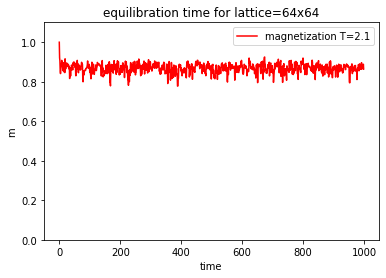

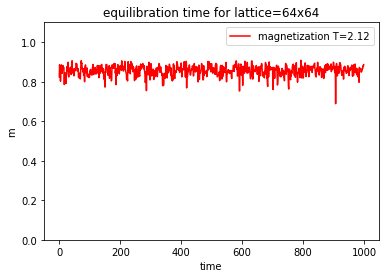

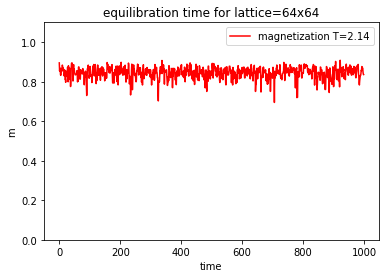

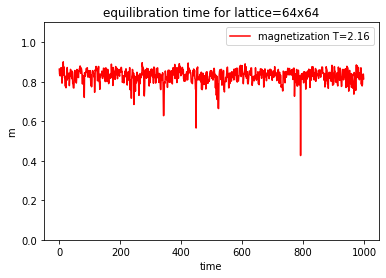

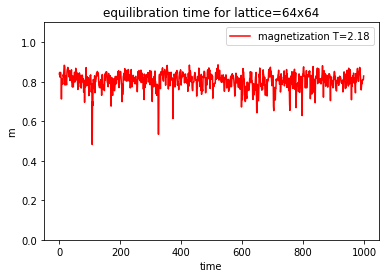

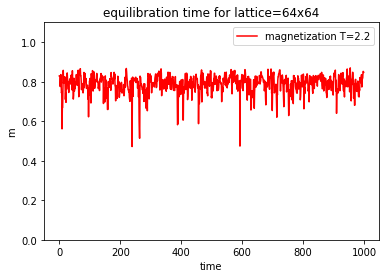

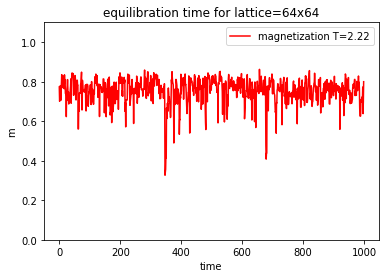

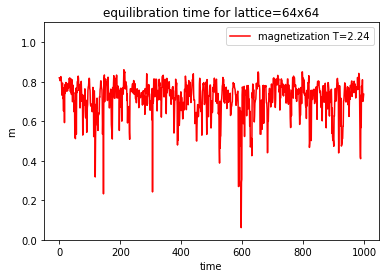

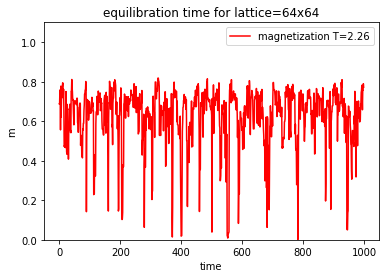

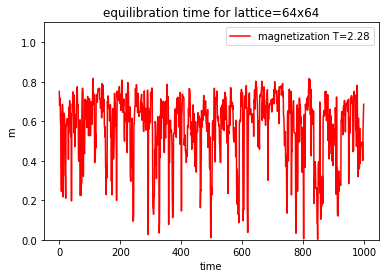

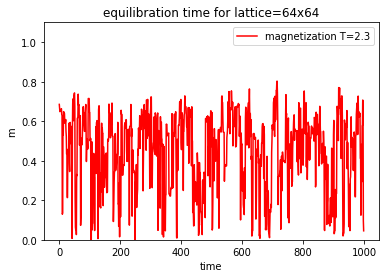

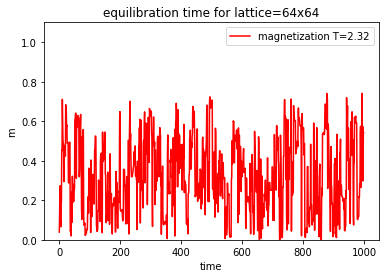

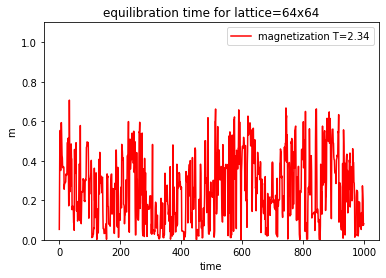

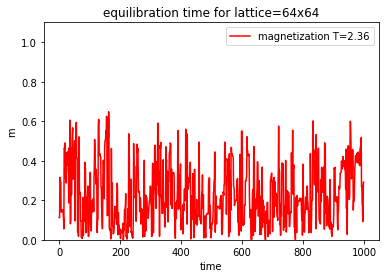

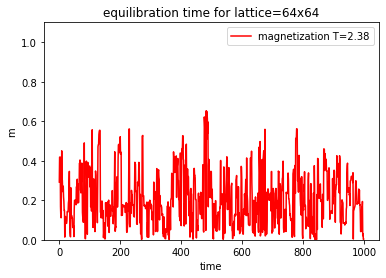

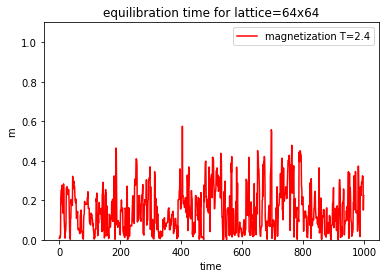

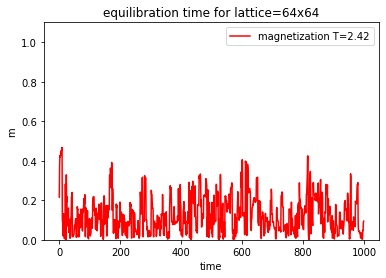

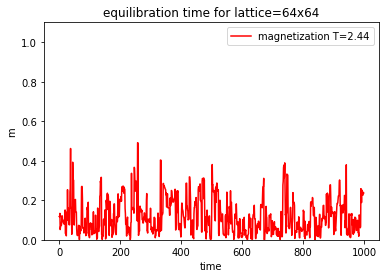

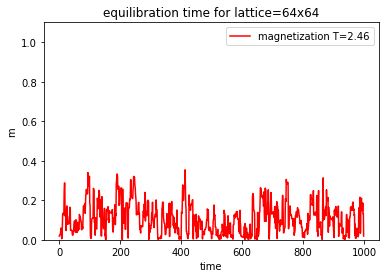

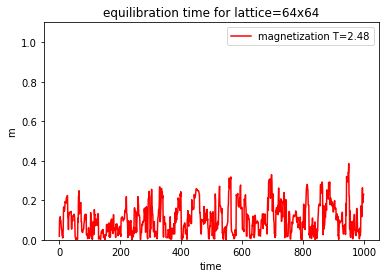

In [0]:
wolff64 = Measurements(64,m_E_data64)
wolff64.equilibration()

In [0]:
wolff64.lists_after_equilibration(800)
wolff64.plot_correlation(5)

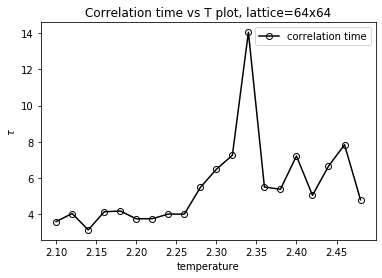

In [0]:
wolff64.temp_vs_corr()

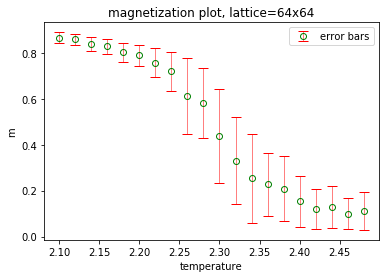

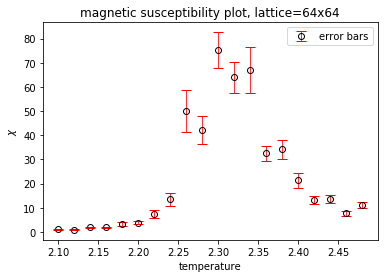

In [0]:
wolff64.final_measurements_wolff()
wolff64.plot_magnetization()
wolff64.plot_mag_susceptibility()